# Lid-Driven Cavity Flow Problem

The problem to be simulated here is the flow of water in a small, square cavity, with a constantly flowing current just above it. This situation occurs in reality when we have a flow, for example a river, going over uneven ground. Because of this, we will define the top, or "lid" of the simulation to have a constant flow.


We complete this using the predictor-corrector step model. In this model, we calculate a starred velocity without the influence of pressure, in the explicit predictor step. This starred velocity is then used to calculate the next values of pressure, using the pressure poisson equation. Finally, we use the implicit corrector step to calculate the true next velocity, using the starred velocities and the pressure.

This method represents a mixture between that of Professor Lorena Barba, in the [12-steps to Navier Stokes](https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/), and Mark Owkes' [A guide to writing your first CFD solver](https://www.montana.edu/mowkes/research/source-codes/GuideToCFD_2020_02_28_v2.pdf). The code is modified to make use of OOP, to make the code as readable as possible.

## The Process

### Grid

In this simulation, we use numerical methods (finite difference methods) to solve the Navier Stokes PDEs for given conditions. This allows us to simulate an advance in time through a time-discretisation method, such that we can model fluid flow over time, with given boundary conditions. Although many numbers of points and total area can be covered by this simulation, we use a 40x40 grid, covering a 2x2 area.

### Boundary Conditions

We must define our boundary conditions, that do not change over the time-frame of the simulation. The two possible options here are "Dirichlet", where the velocities and pressure are fixed at the boundary, or "Neumann", where the value of the derivative is fixed at the boundary. In this case, we are using Dirichlet boundary conditions for the velocities, and a mixture of Dirichlet and Neumann boundary conditions for the pressure.

The x-velocity has boundary conditions of 0 on the sides and bottom, and a variable value `lid_vel` on the top, or lid. This is to represent the flow above the cavity. The y-velocity is set to 0 on all boundaries.

The pressure has its derivative with respect to x set to 0 on the sides, and the derivative with respect to y set to 0 on the bottom. The pressure is set to 0 (fixed) at y = 2.

### Computing Starred Velocities

In this step, we perform the predictor-step to calculate the starred velocities. This is using the following equation, from Owkes (2020):

$$ u^* = u^n + \Delta t (\nu (\nabla^{2}u^n) - (u^n \frac{\delta u^n}{\delta x} + v^n \frac{\delta u^n}{\delta y}))$$

$$ v^* = v^n + \Delta t (\nu (\nabla^{2}v^n) - (u^n \frac{\delta v^n}{\delta x} + v^n \frac{\delta v^n}{\delta y}))$$

In these equations, $\nu$ represents the viscosity term.

### Computing the Pressure with the Pressure-Poisson Equation

We calculate the pressure at the next step, using our previously found starred velocities. The equations for this are long and complicated, so will not be typed out here.

We start with defining a term b, that will be used to simplify later equations.

### Corrector Step

Lastly, we perform the corrector step, which gives us the velocities at the next time-step

### Display

Finally, we use a quiver plot to display both the movement of the fluid at any given time, along with the pressure areas in the fluid. Here, we will see that fluid flows from areas of high pressure to low pressure, except for when it is carried by the lid-flow.

## Import Libraries

The only libraries we'll use in this project are NumPy for matrix manipulation, and matplotlib to plot our results.

In [1]:
import numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib notebook

## Discretisation with Finite Difference Functions

As we have to do the finite difference method many times in order to update our equations, we can create functions for these, in order to make the code more readable and less repetitive. These utility functions will be defined outside of the class for the cavity flow, as they are general.

In [2]:
#The first difference approximates the derivative with respect to y or x
# At the given point. We do this for the whole array at once

def diff_1st_x(f,dx):
    return (f[1:-1, 2:] - f[1:-1,0:-2])/(2*dx)

def diff_1st_y(f,dy):
    return (f[2:, 1:-1] - f[0:-2,1:-1])/(2*dy)


#The second difference approximates the second derivative
# with respect to x or y
def diff_2nd_x(f,dx):
    # f(i-1,j) + 2*f(i,j) + f(i+1,j) 
    return ((f[1:-1,0:-2] - 2*f[1:-1,1:-1] + f[1:-1,2:]) / dx**2) 
  
def diff_2nd_y(f,dy):
    # f(i,j-1) + 2*f(i,j) + f(i,j+1) 
    return ((f[0:-2,1:-1] - 2*f[1:-1,1:-1] + f[2:,1:-1]) / dy**2)


#A laplacian is defined as the sum of the second differences
# with respect to x and y
def laplacian(f, dx, dy):
    return (diff_2nd_x(f, dx) + 
            diff_2nd_y(f, dy))

## Define Cavity Class

Here, we define a class for cavity flow, in which our simulation takes place. This will take input terms as follows:

- Definitions of the grid to be simulated upon
- Boundary conditions
- Lid flow velocity
- Length of a single time step
- Density of the fluid
- Viscosity of the fluid



The updating of the state of the simulation will also take place here. In this, we will use a single `update()` method, which will advance the simulation by one time step. Updating the simulation involves both the predictor and corrector step, in which we first use an explicit numerical method (predictor step) to find new starred velocities. After this, we calculate the pressure at each grid point, and then use an implicit numerical method (corrector step) to update the velocities as a result of this pressure.

In [3]:
class Cavity:
    """
    2D Cavity Flow Simulation
    
    Input parameters:
    n - tuple - a tuple containing the number of points in each direction (x, y)
    x_bound - tuple - a tuple containing the boundary coordinate for each edge 
                      of the x axis (min, max)
    y_bound - tuple - a tuple containing the boundary coordinate for each edge
                      of the y axis (min, max)
    lid_vel - float - a float determining the constant rate of flow of the lid of the cavity
    dt - float - the difference in time between time-steps
    rho - float - the density of the fluid
    vis - float - the viscosity of the fluid
    """
    
    
    def __init__(self, n, x_bound, y_bound, lid_vel, dt, rho, vis):
        ## Initial parameters
        self.lid_vel = lid_vel
        self.dt = dt
        self.rho = rho
        self.vis = vis
        
        
        ##Define meshes and storage grids
        
        #X mesh, with n[0]+1 total points representing n divisions
        nx = n[0]+1
        x_min, x_max = x_bound
        self.x_min = x_min
        self.x_max = x_max
        self.nx = nx

        #Y mesh, again n+1 total points representing n divisions
        ny = n[1]+1
        y_min, y_max = y_bound
        self.y_min = y_min
        self.y_max = y_max
        self.ny = ny

        #Find the difference in x and y between points on the grid
        self.dx = (x_max - x_min)/ (nx-1)
        self.dy = (y_max - y_min)/ (ny-1)

        #Create blank storage grids for x-velocity, y-velocity, and pressure
        self.u = np.zeros((ny, nx))
        self.v = np.zeros((ny, nx))
        self.p = np.zeros((ny, nx))
        
        
        #Set the pressure and velocity boundary conditions
        self.set_velocity_boundary()
        self.set_pressure_boundary()
        
    def set_velocity_boundary(self):
        #Sets the velocity boundary conditions of the cavity flow model
        # according to pre-defined boundary conditions
            
            
        #Set u boundary conditions
        self.u[0, :]  = 0
        self.u[:, 0]  = 0
        self.u[:, -1] = 0 
        #The lid has x-velocity of lid_vel - the flow on top of the cavity
        self.u[-1, :] = self.lid_vel

        #Set v boundary conditions
        self.v[0, :]  = 0
        self.v[:, 0]  = 0
        self.v[:, -1] = 0 
        self.v[-1, :] = 0
        
    def set_pressure_boundary(self):
        #Sets the pressure boundary conditions of the cavity flow model
        # according to the pre-defined boundary conditions
        
        #Neumann conditions
        self.p[:, -1] = self.p[:, -2] #This makes dp/dx = 0 at x = 2
        self.p[0, :] = self.p[1, :]   #This makes dp/dy = 0 at y = 0
        self.p[:, 0] = self.p[:, 1]   #This makes dp/dx = 0 at x = 0

        #Dirichlet Condition
        self.p[-1, :] = 0            
        
    def get_starred_velocities(self):
        #Create copies for new values to be calculated in
        u_star = self.u.copy()
        v_star = self.v.copy()
        
        un = self.u.copy()
        vn = self.v.copy()
        
    
        #Compute u_star
        u_star[1:-1,1:-1] = (self.vis * laplacian(un, self.dx, self.dy) -
                             (un[1:-1, 1:-1]*diff_1st_x(un,self.dx) + 
                              vn[1:-1, 1:-1]*diff_1st_y(un,self.dy))
                              )*self.dt + un[1:-1, 1:-1]
    
        #Compute v_star
        v_star[1:-1,1:-1] = (self.vis * laplacian(vn, self.dx, self.dy) -
                             (un[1:-1, 1:-1]*diff_1st_x(vn,self.dx) + 
                              vn[1:-1, 1:-1]*diff_1st_y(vn,self.dy))
                              )*self.dt + vn[1:-1, 1:-1]
    
    
        return u_star, v_star
        
        
    def get_b(self, u_star, v_star):
        #Define b term to make later calculation easier
        divergence_vel_star = (diff_1st_x(u_star, self.dx) +
                               diff_1st_y(v_star, self.dy))
    
        b = (self.rho / self.dt) * divergence_vel_star
    
        return b
    
    def pressure_poisson(self, b):
        pn = self.p.copy()
    
    
        #We split this equation into 3 terms to make it more readable
        term1 = (pn[1:-1,0:-2] + pn[1:-1,2:]) * self.dy**2
    
        term2 = (pn[0:-2,1:-1] + pn[2:,1:-1]) * self.dx**2
    
        term3 = -(b * (self.dx**2 * self.dy**2))
    
        #Now, we finally calculate the new pressures:
        self.p[1:-1, 1:-1] = (
            (term1 + term2 + term3) / (2*(self.dx**2 + self.dy**2))
        )
    
    def corrector_step(self, u_star, v_star):
        u = u_star.copy()
        v = v_star.copy()
    
        u[1:-1, 1:-1] = (-self.dt/self.rho) * (diff_1st_x(self.p, self.dx)) + u_star[1:-1,1:-1]
        v[1:-1, 1:-1] = (-self.dt/self.rho)*(diff_1st_y(self.p, self.dy)) + v_star[1:-1,1:-1]
    
        self.u = u
        self.v = v
        
    def update(self):
        #Predictor step
        u_star, v_star = self.get_starred_velocities()
        
        #Solve for next pressure
        b = self.get_b(u_star, v_star)
        self.pressure_poisson(b)
        self.set_pressure_boundary()
        
        #Corrector step
        self.corrector_step(u_star, v_star)
        
        self.set_velocity_boundary()
        
    def display(self):
        x = np.linspace(self.x_min, self.x_max, self.nx)
        y = np.linspace(self.y_min, self.x_max, self.ny)
        X, Y = np.meshgrid(x,y)
        
        #Quiver plot

        fig = plt.figure(figsize=(11,7), dpi=100)
        # plotting the pressure field as a contour
        plt.contourf(X, Y, self.p, alpha=0.5, cmap=cm.viridis)
        plt.colorbar()
        # plotting the pressure field outlines
        plt.contour(X, Y, self.p, cmap=cm.viridis)
        # plotting velocity field
        plt.quiver(X[::2, ::2], Y[::2, ::2], self.u[::2, ::2], self.v[::2, ::2])
        plt.xlabel('X')
        plt.ylabel('Y');


In [4]:
#Define parameters

rho = 1 # density
vis = .1 # viscosity coefficient
dt = .001 # timestep
n = (40, 40) #grid-size
x_bound = (0, 2) #x boundary size
y_bound = (0, 2) #y boundary size
lid_vel = 1 #velocity of the lid flow

sim = Cavity(n, x_bound, y_bound, lid_vel, dt, rho, vis)

<IPython.core.display.Javascript object>


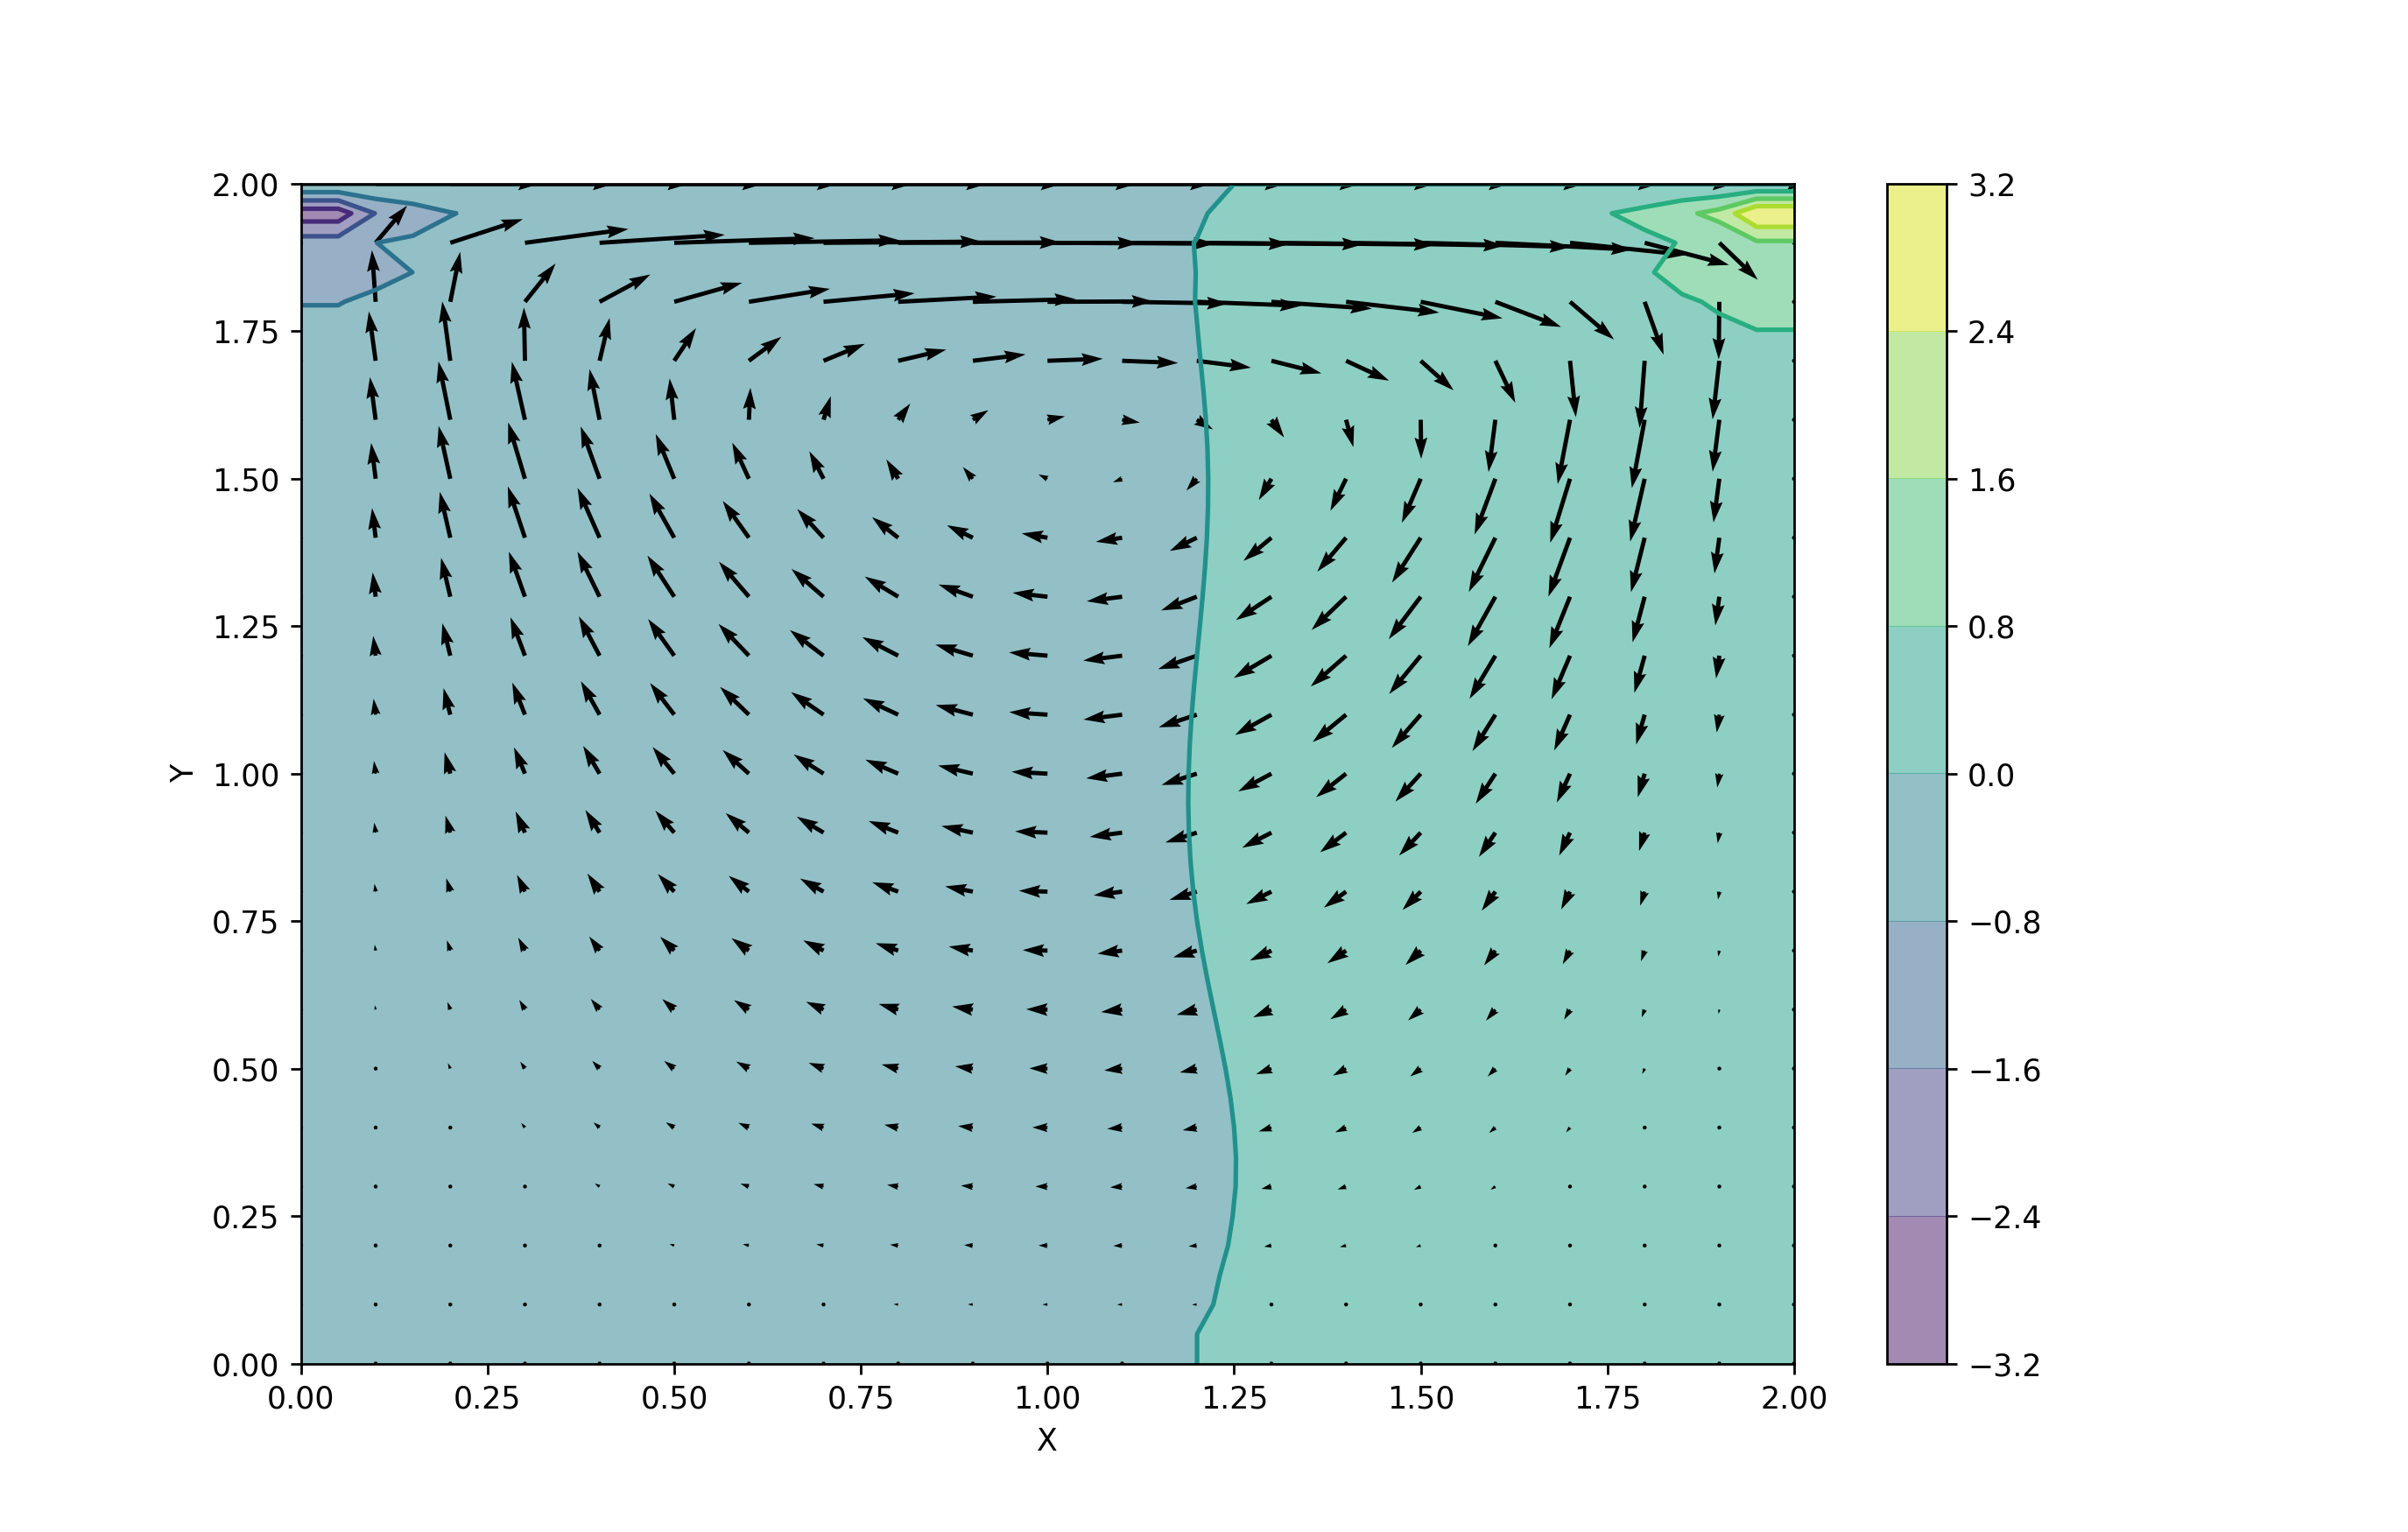

In [5]:
for i in range(1000):
    sim.update()

sim.display()

## Changing Parameters

Here, we will look into the changes brought about by changing the parameters of the model. This will involve using different fluid viscosities, and different lid flow velocities.

<IPython.core.display.Javascript object>


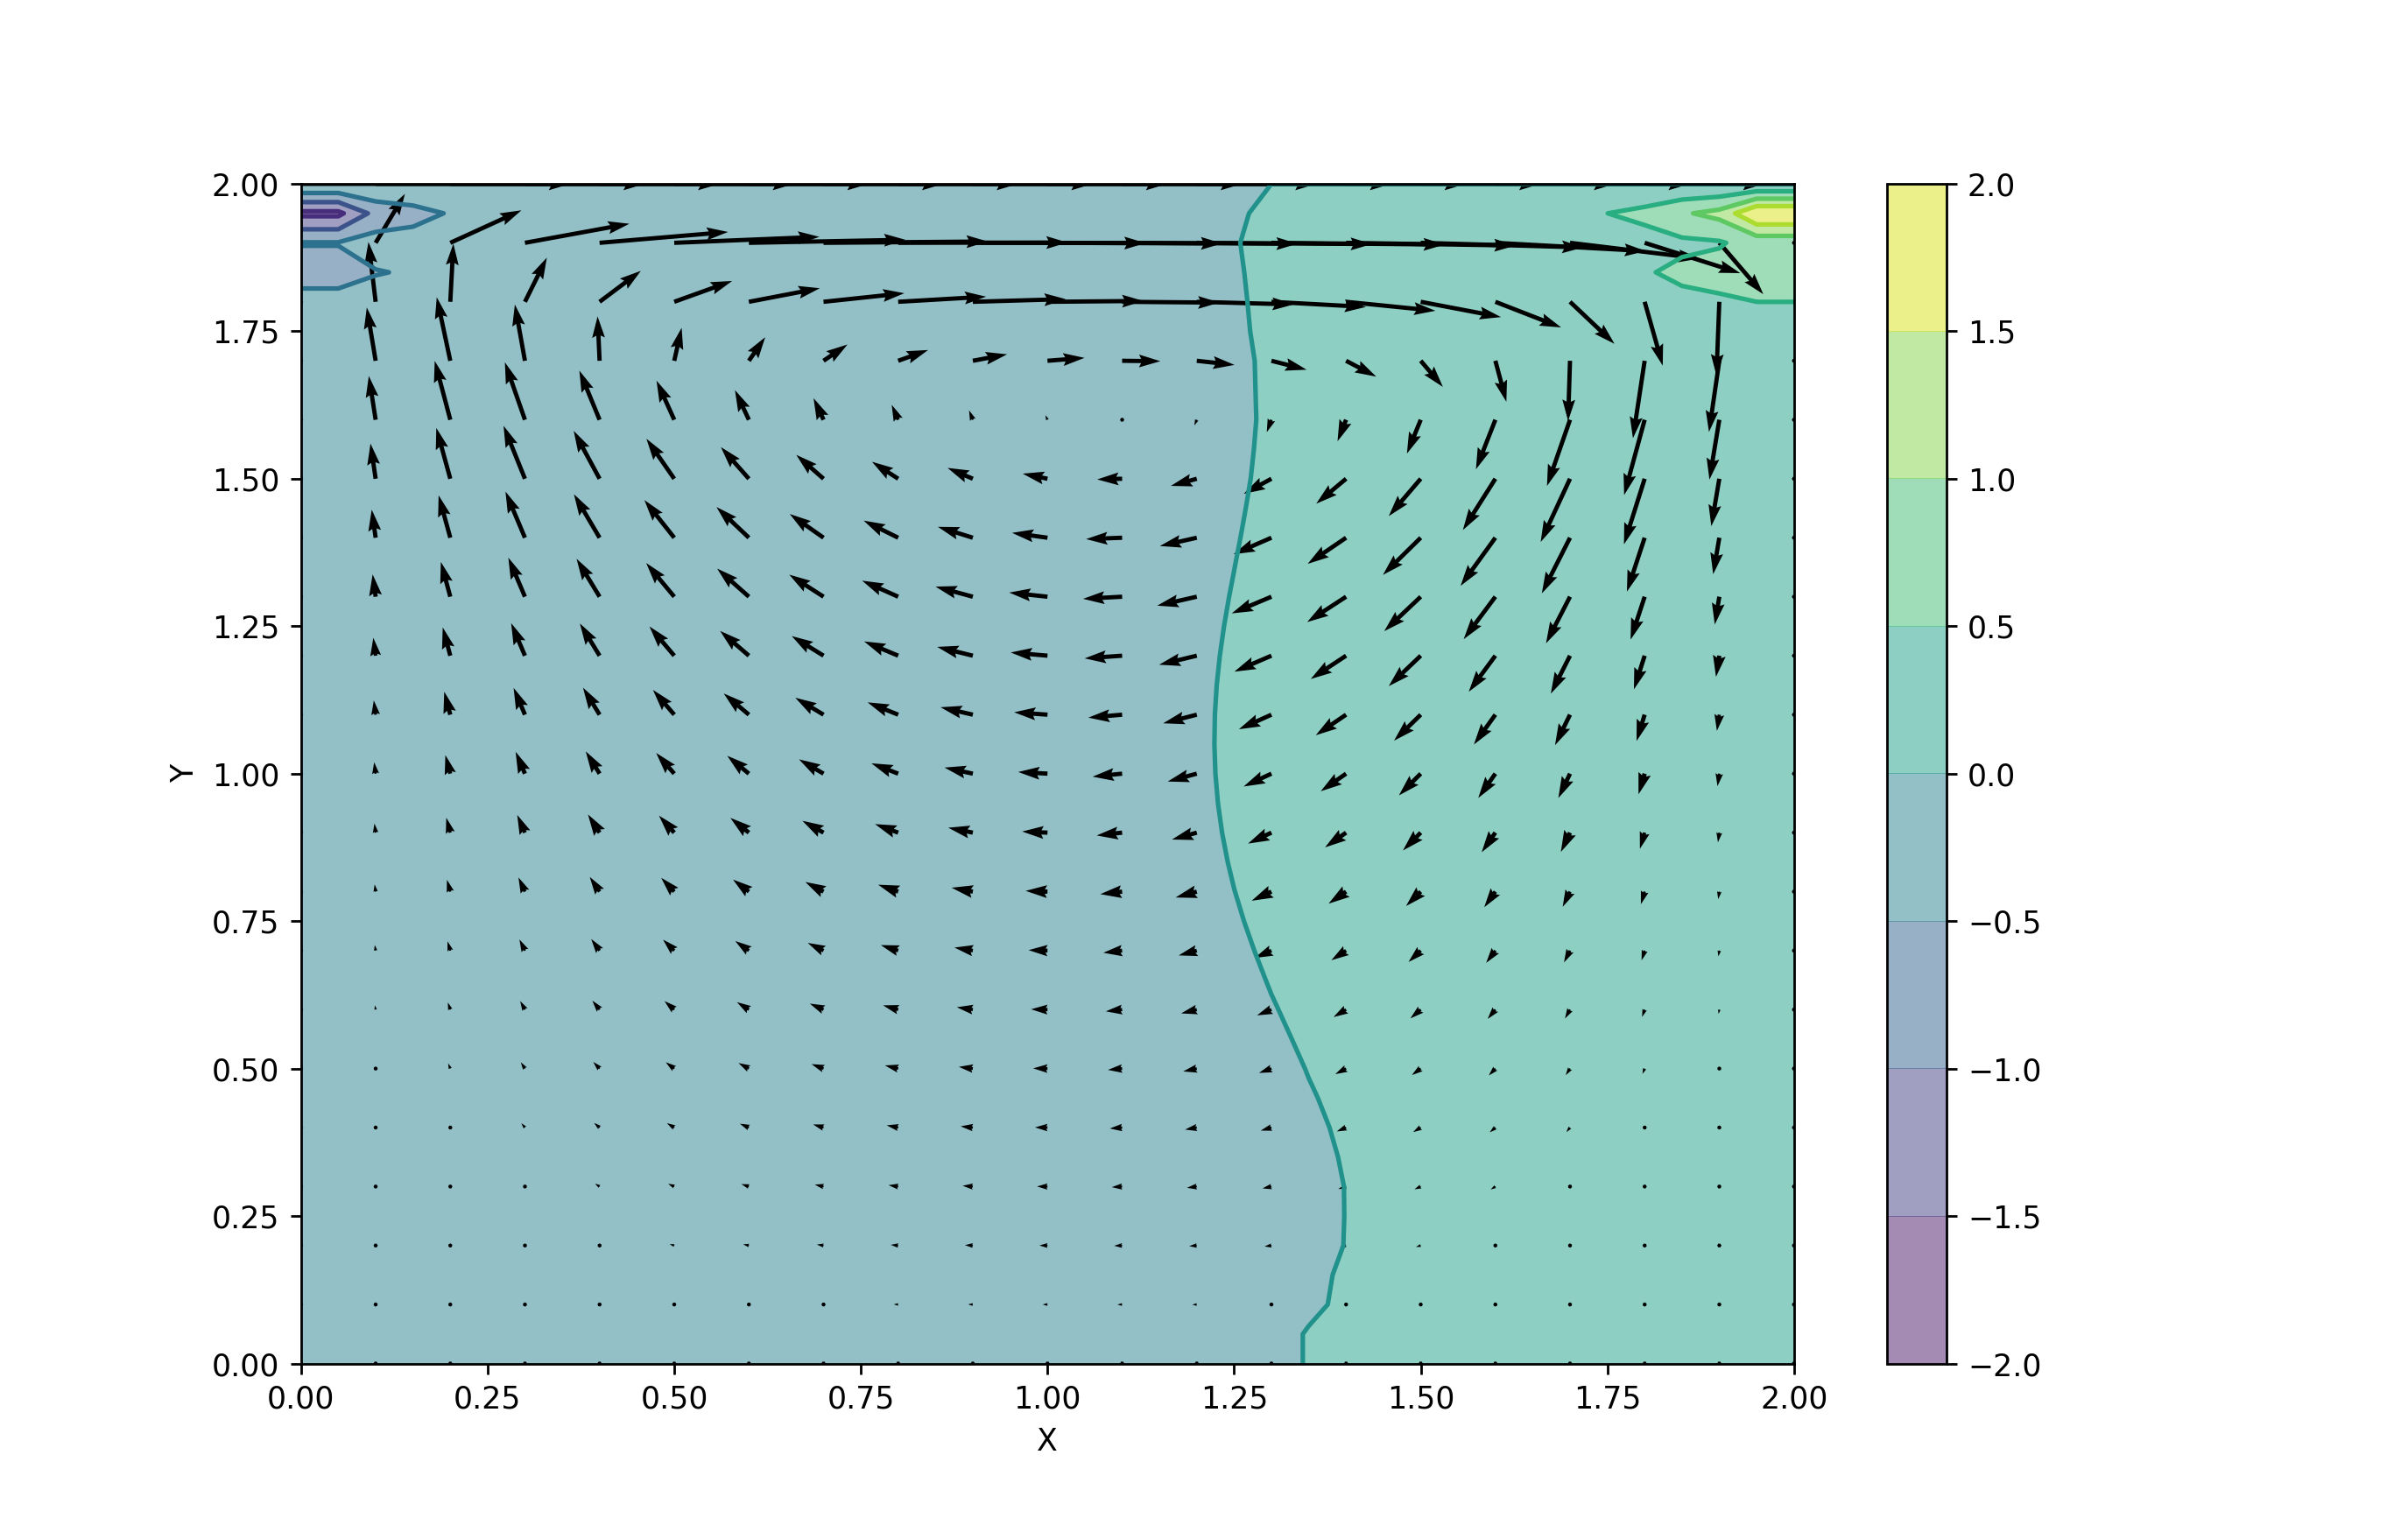

In [6]:
#Define parameters

vis = .05 # viscosity coefficient
lid_vel = 1 #velocity of the lid flow

sim = Cavity(n, x_bound, y_bound, lid_vel, dt, rho, vis)

for i in range(1000):
    sim.update()

sim.display()

<IPython.core.display.Javascript object>


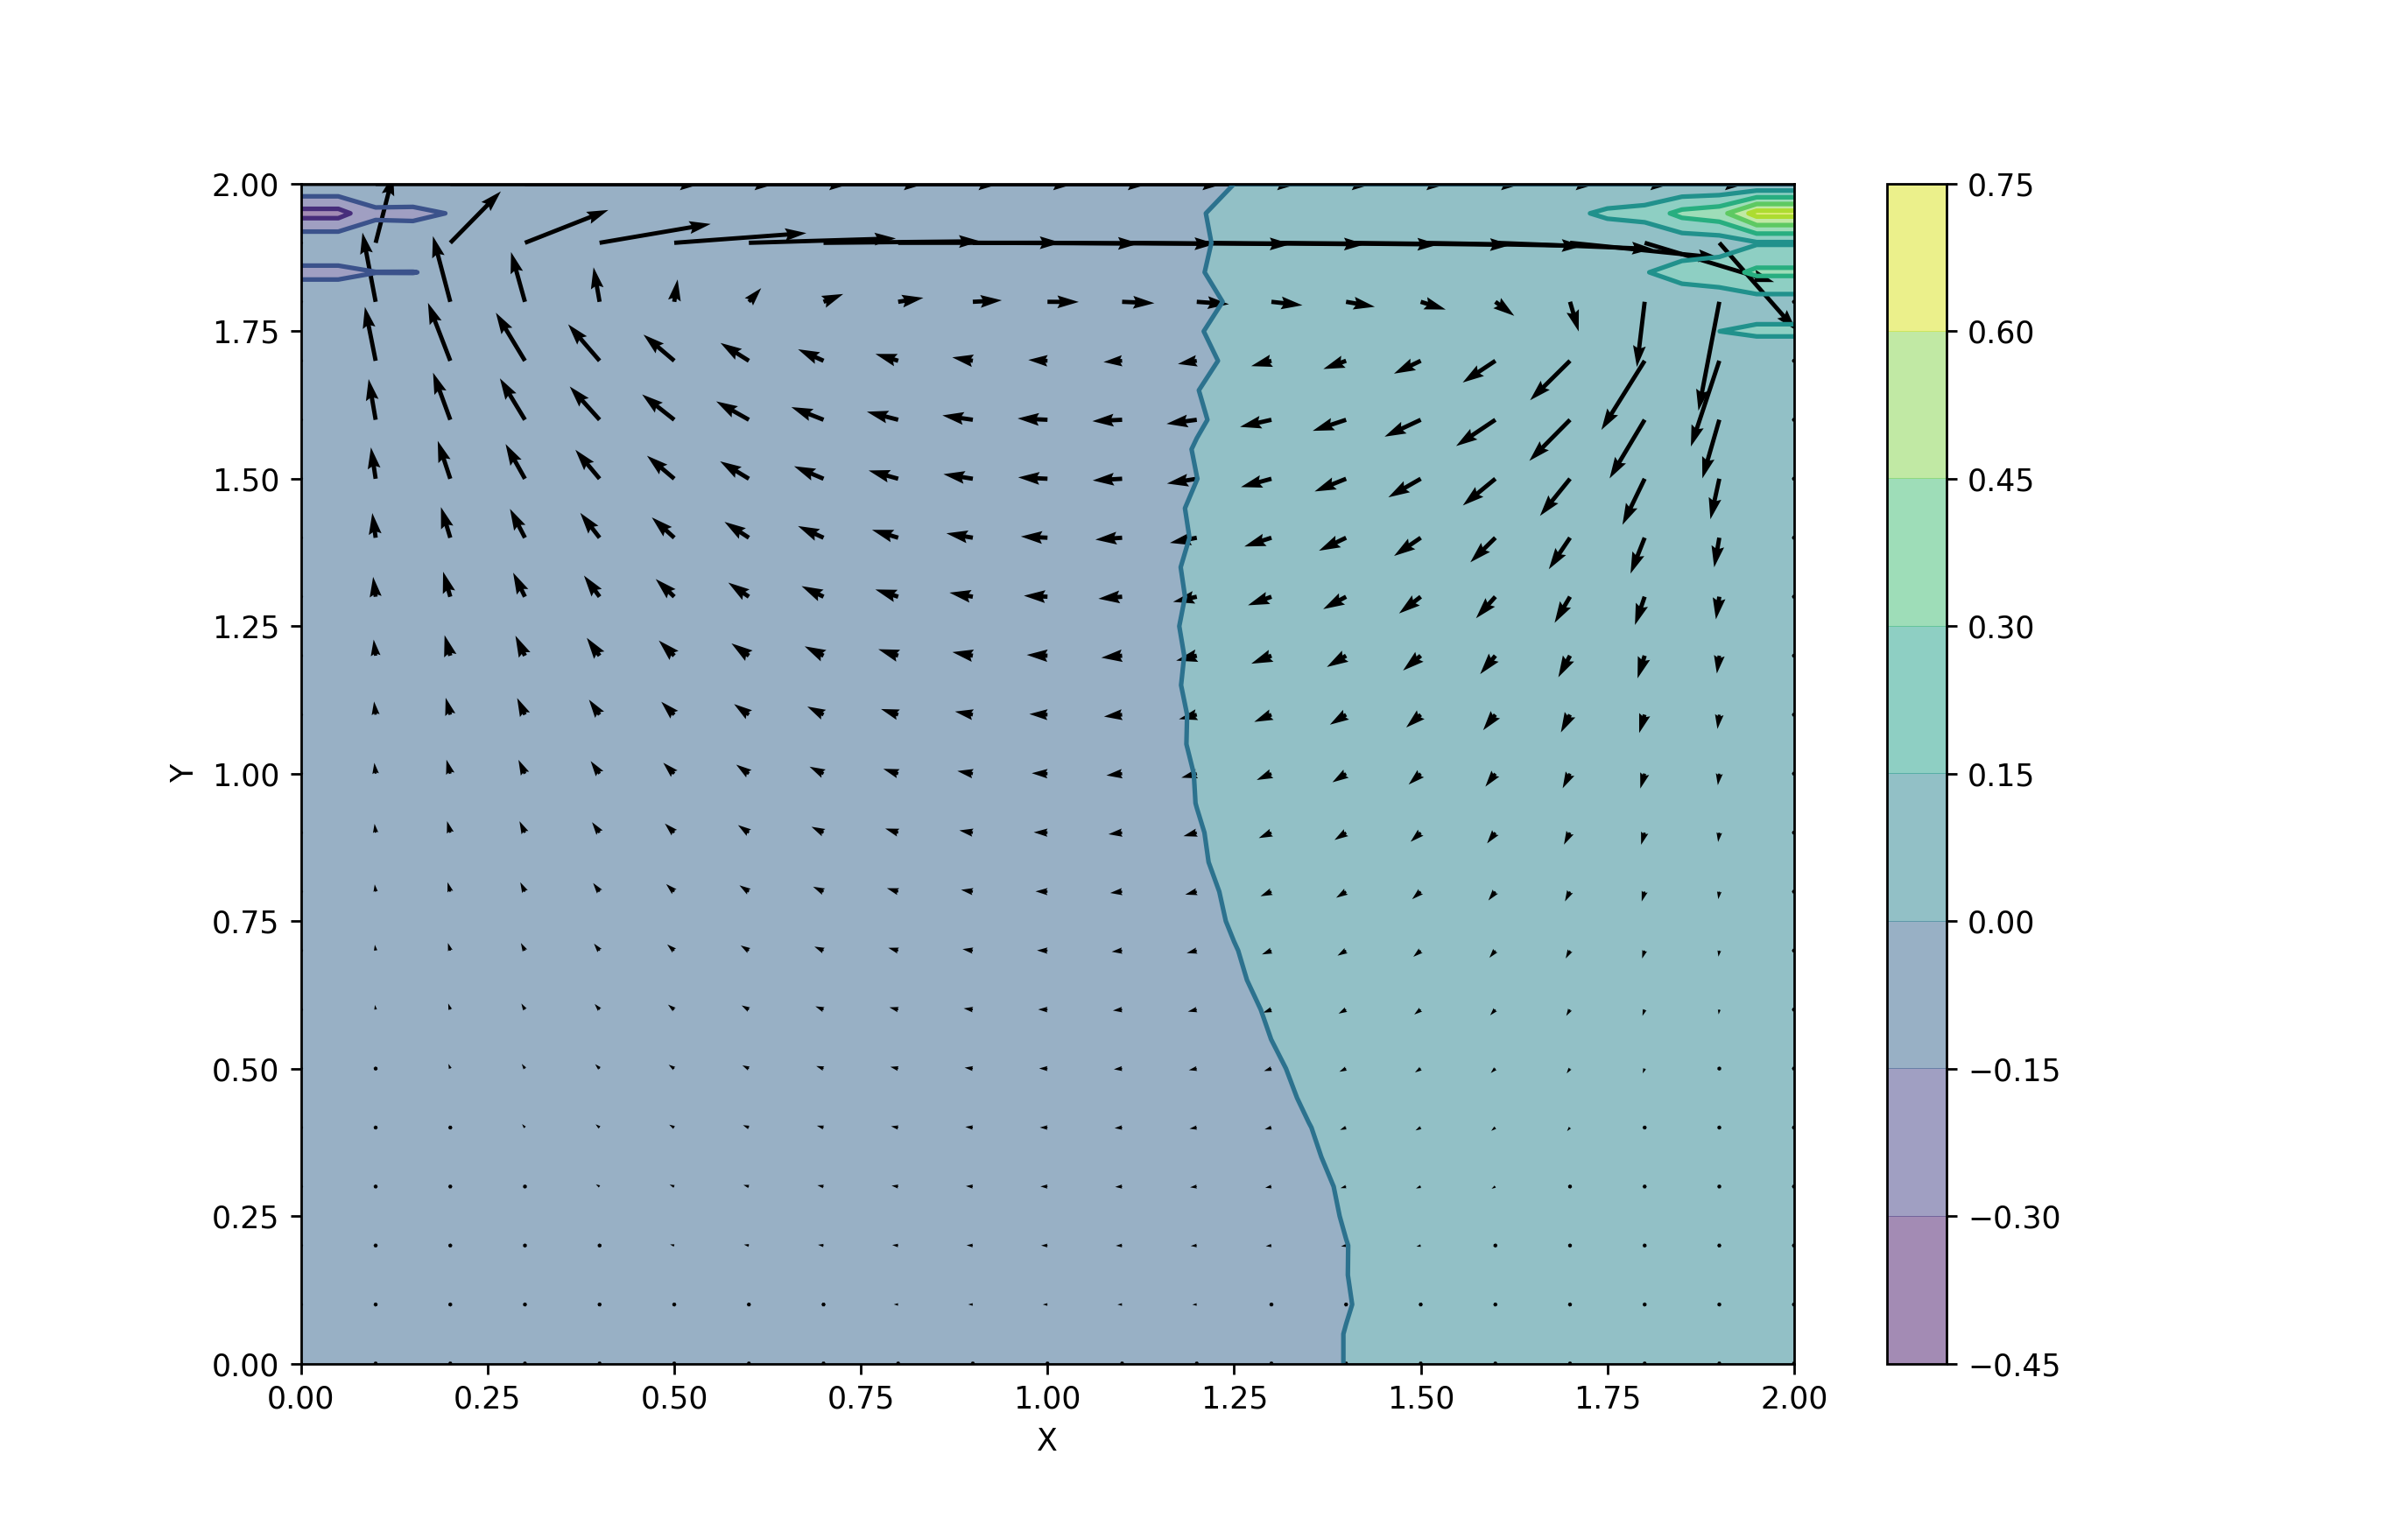

In [7]:
#Define parameters

vis = .01 # viscosity coefficient
lid_vel = 1 #velocity of the lid flow

sim = Cavity(n, x_bound, y_bound, lid_vel, dt, rho, vis)

for i in range(1000):
    sim.update()

sim.display()

<IPython.core.display.Javascript object>


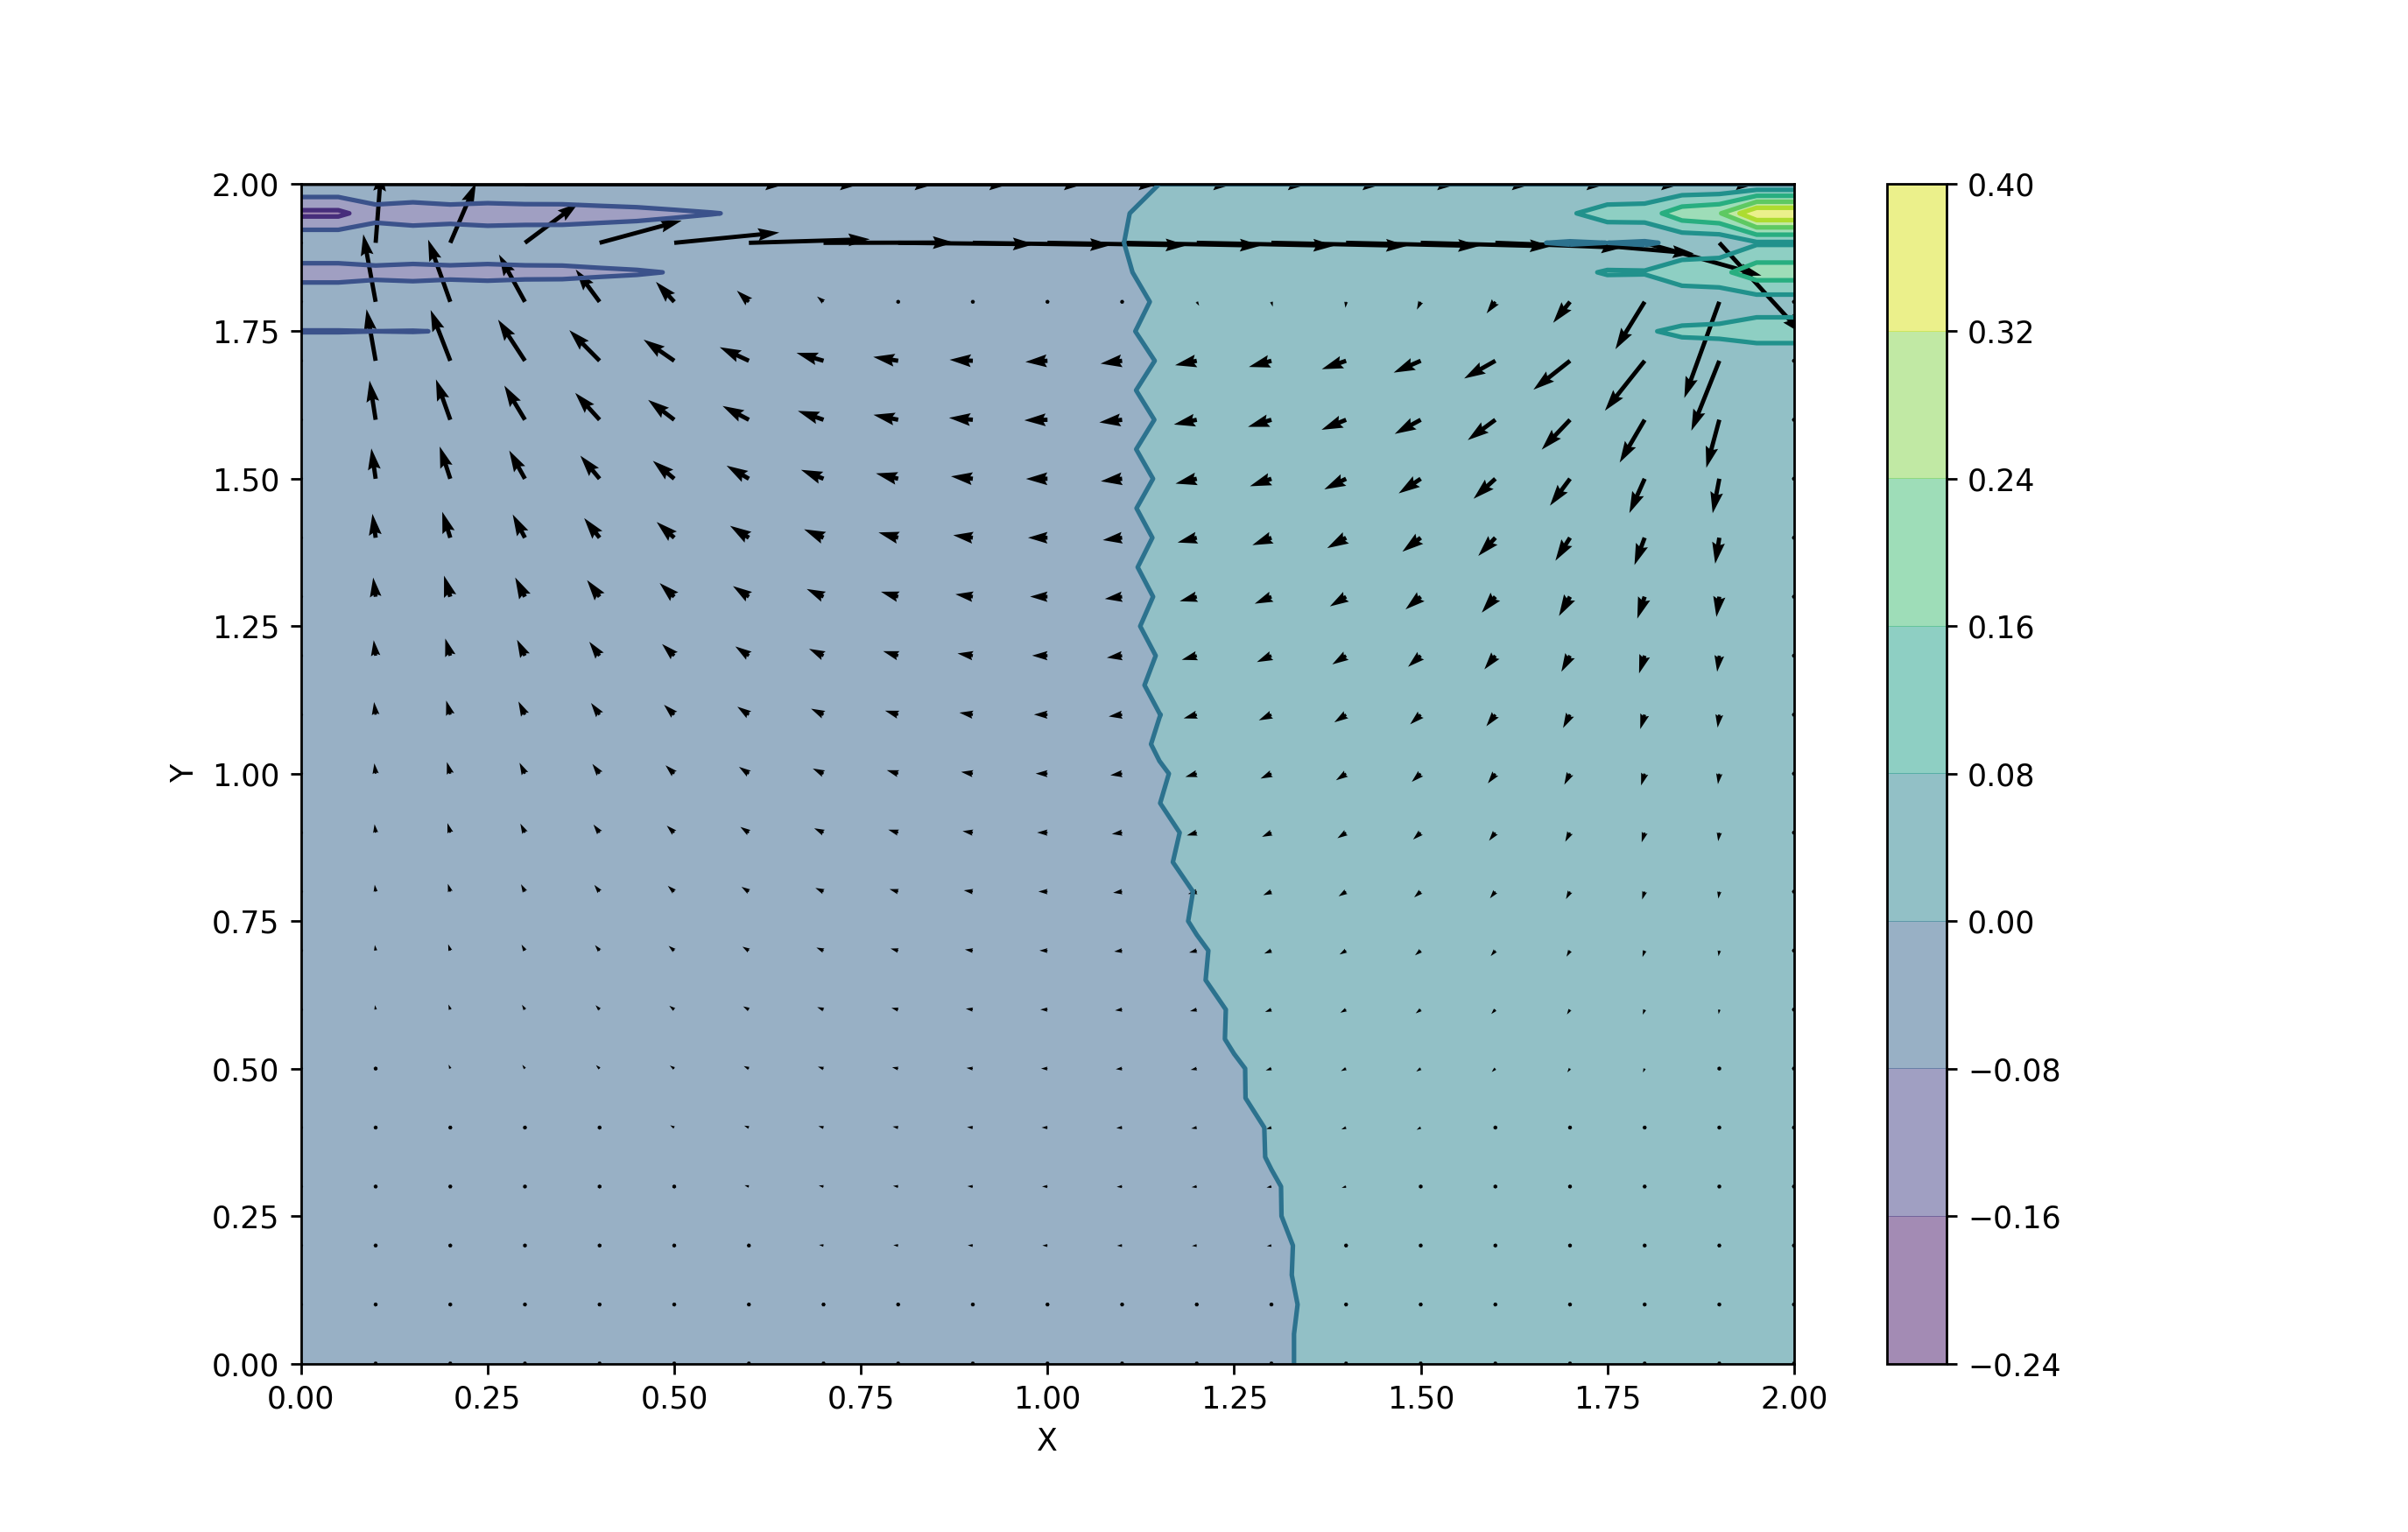

In [8]:
#Define parameters

vis = .005 # viscosity coefficient
lid_vel = 1 #velocity of the lid flow

sim = Cavity(n, x_bound, y_bound, lid_vel, dt, rho, vis)

for i in range(1000):
    sim.update()

sim.display()

<IPython.core.display.Javascript object>


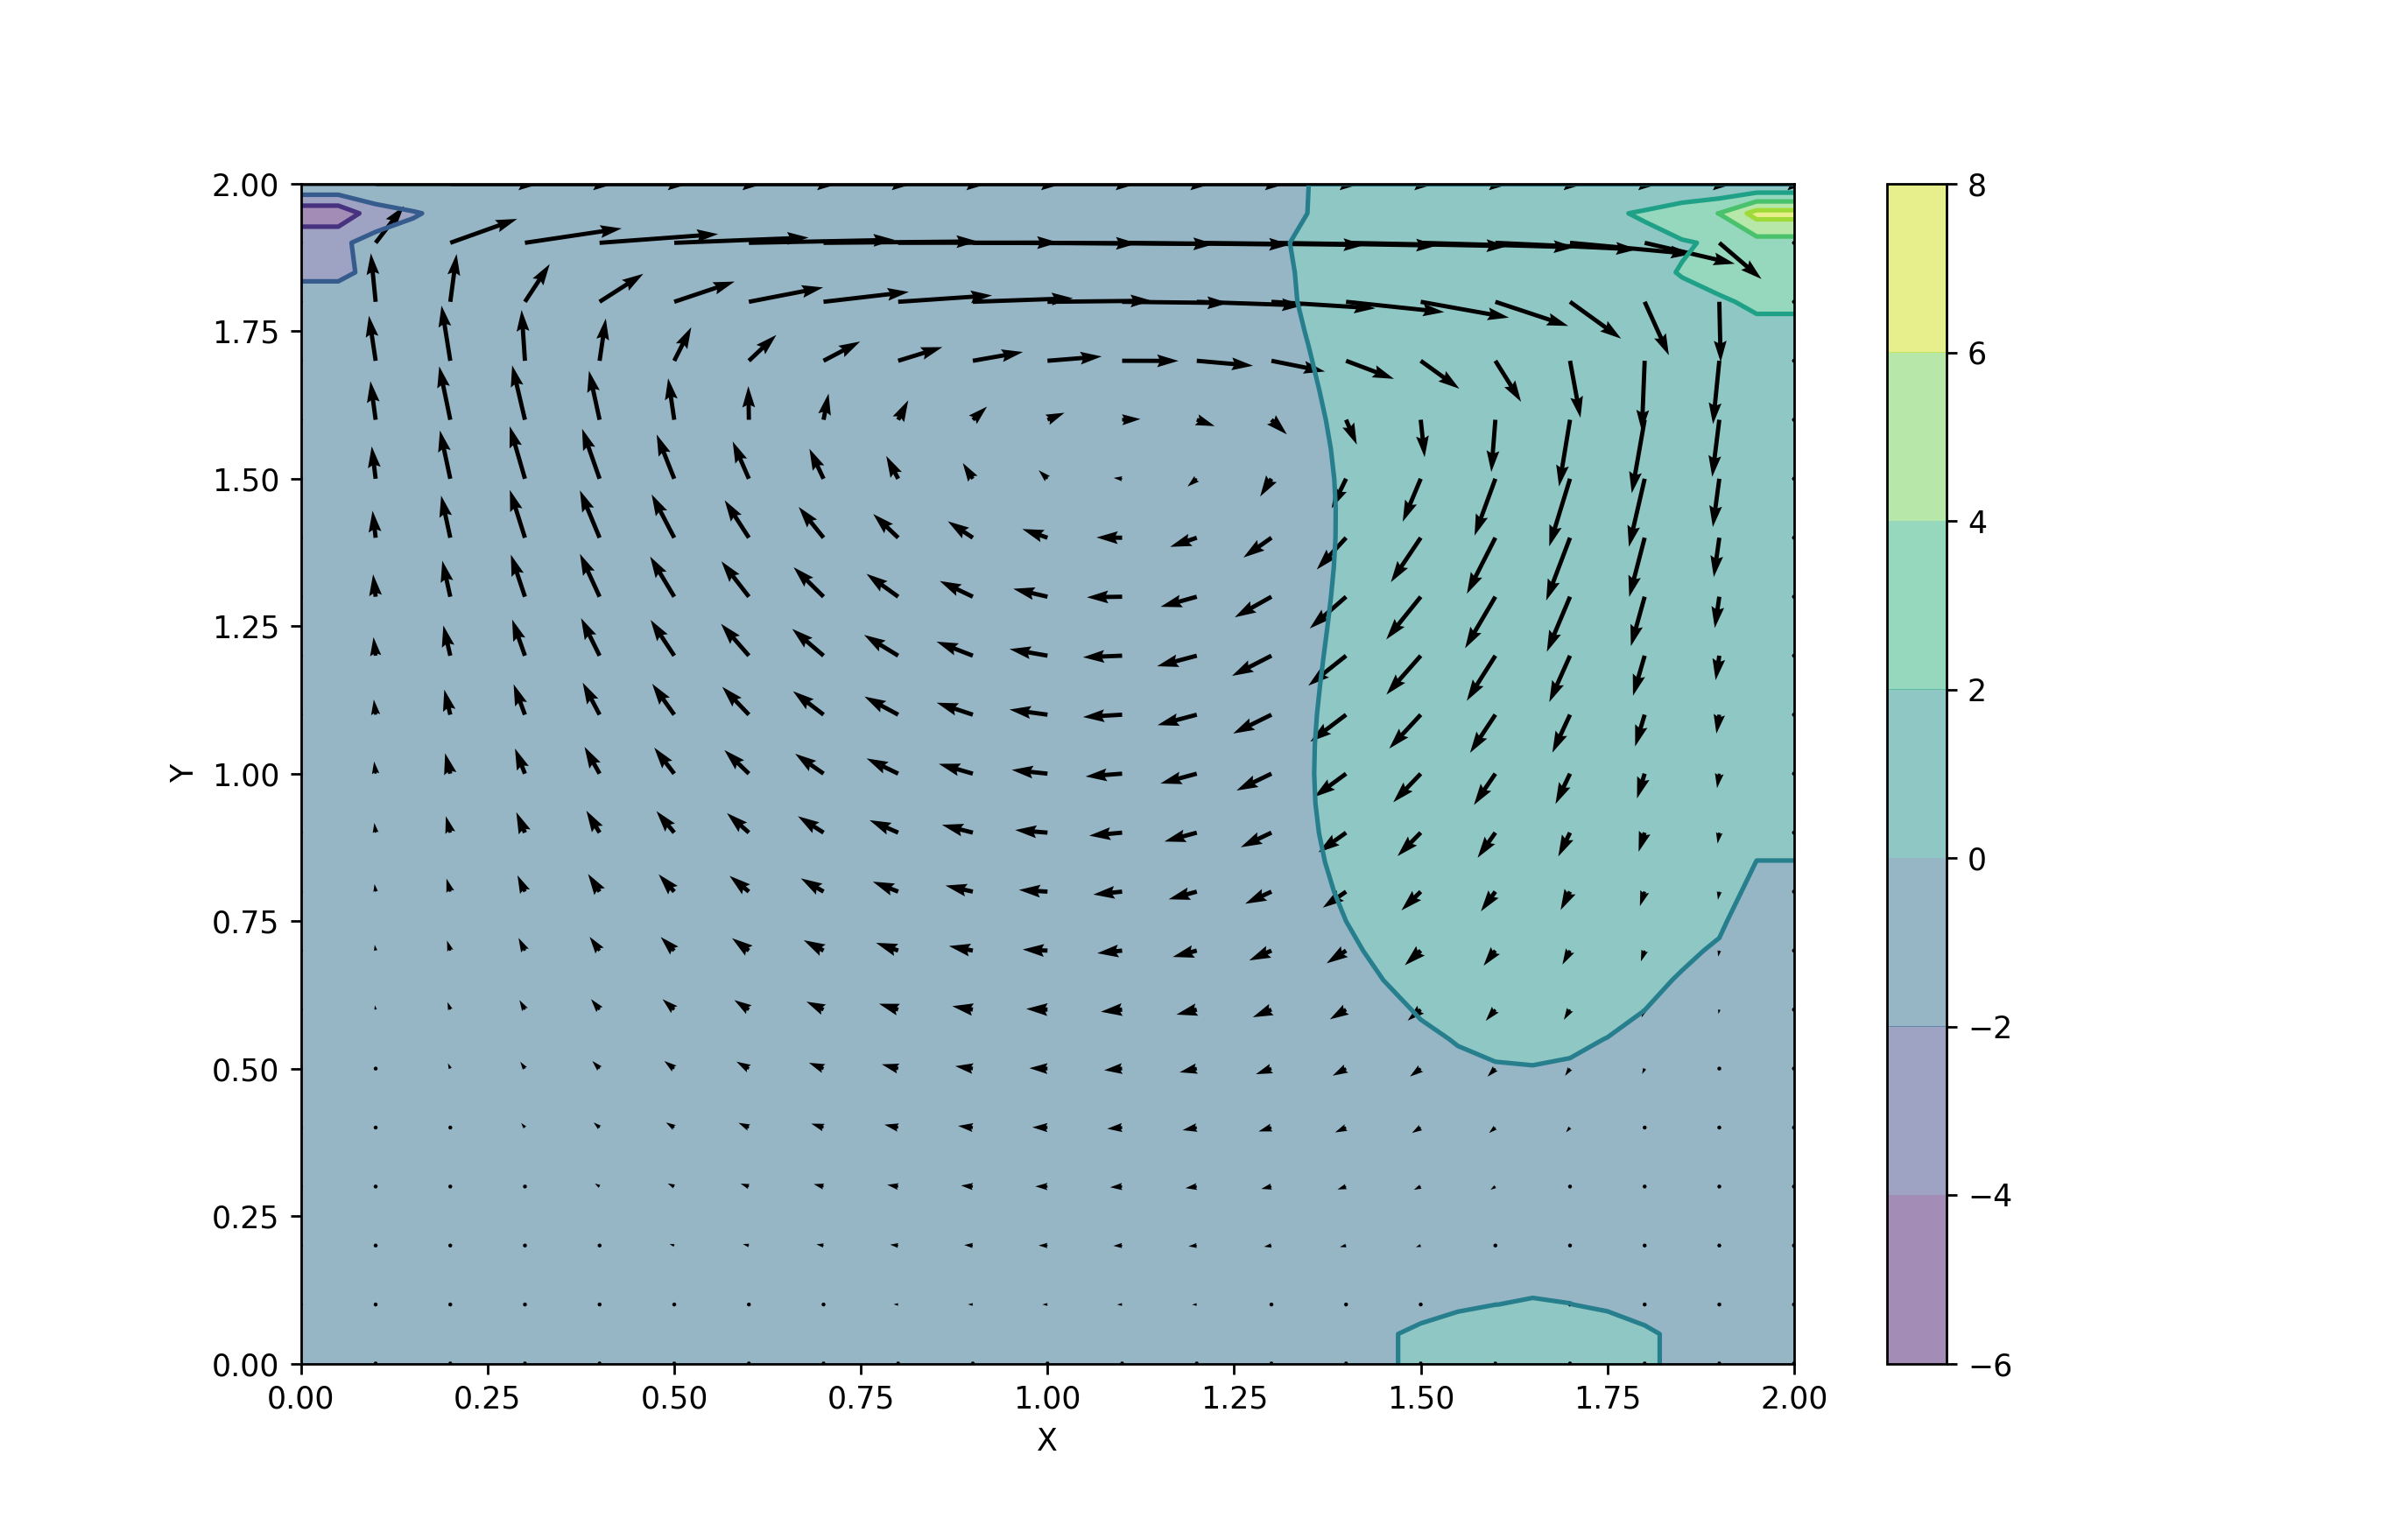

In [9]:
#Define parameters

vis = .1 # viscosity coefficient
lid_vel = 2 #velocity of the lid flow

sim = Cavity(n, x_bound, y_bound, lid_vel, dt, rho, vis)

for i in range(1000):
    sim.update()

sim.display()

<IPython.core.display.Javascript object>


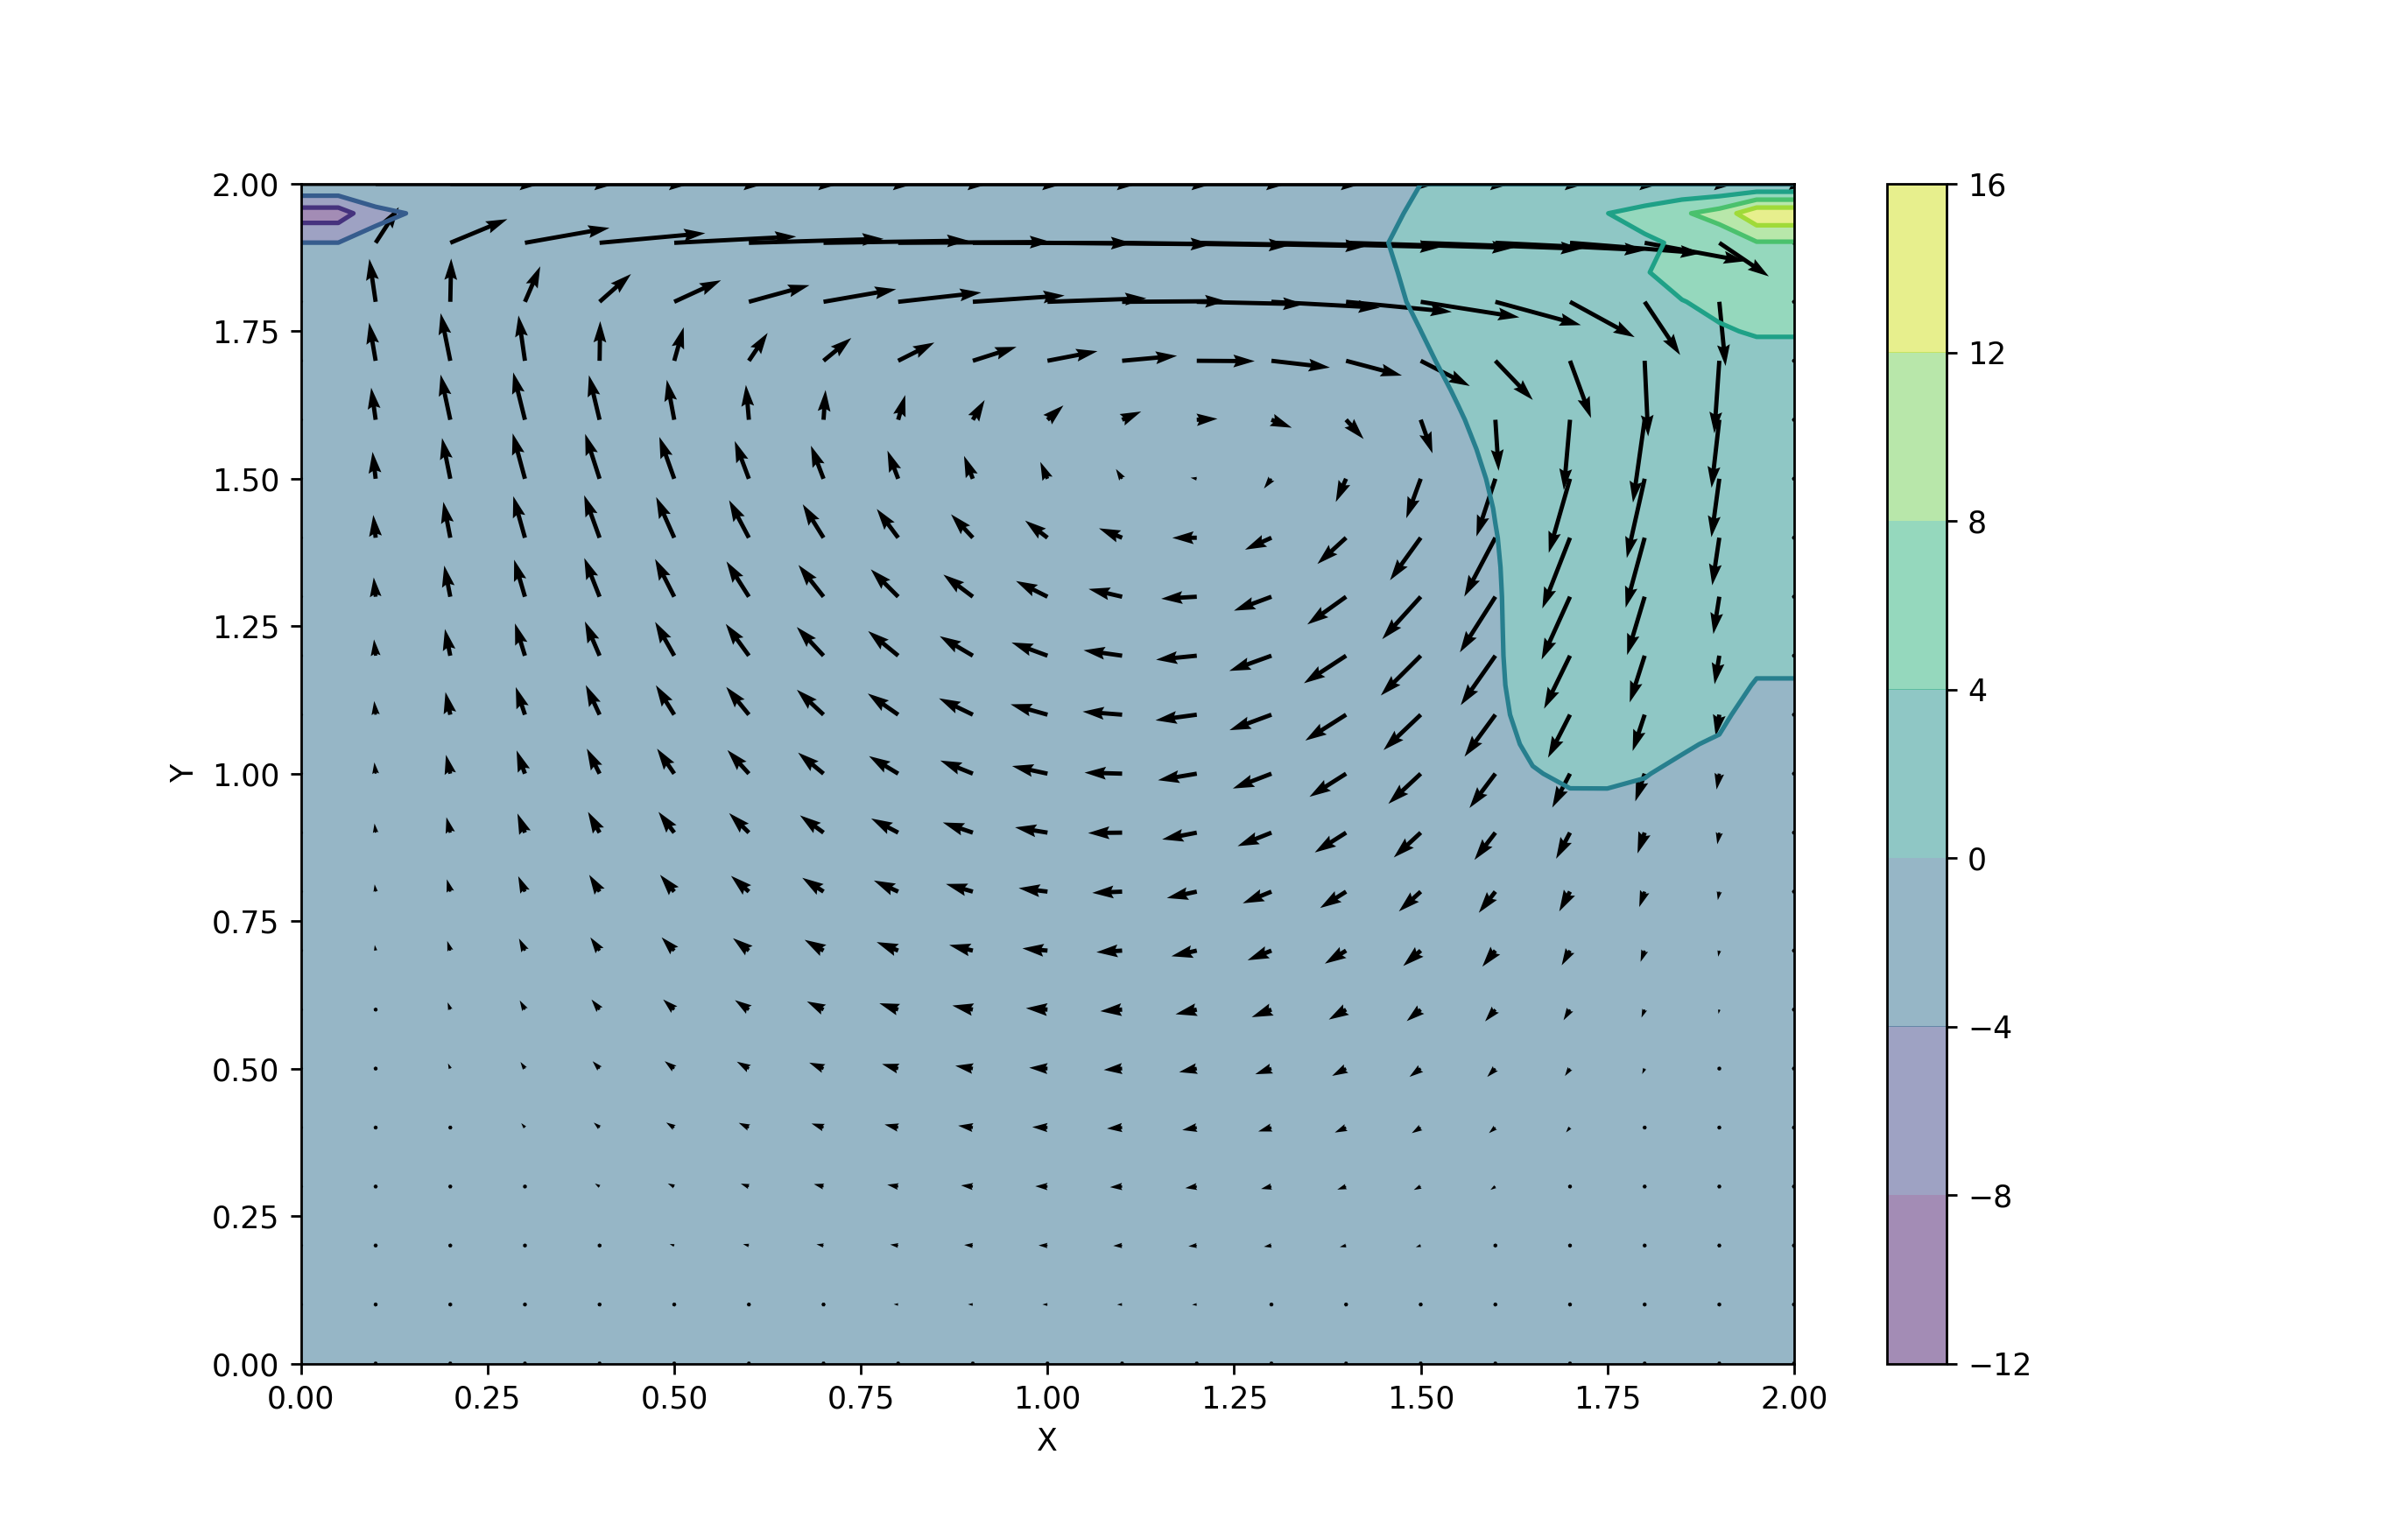

In [10]:
#Define parameters

vis = .1 # viscosity coefficient
lid_vel = 4 #velocity of the lid flow

sim = Cavity(n, x_bound, y_bound, lid_vel, dt, rho, vis)

for i in range(1000):
    sim.update()

sim.display()

<IPython.core.display.Javascript object>


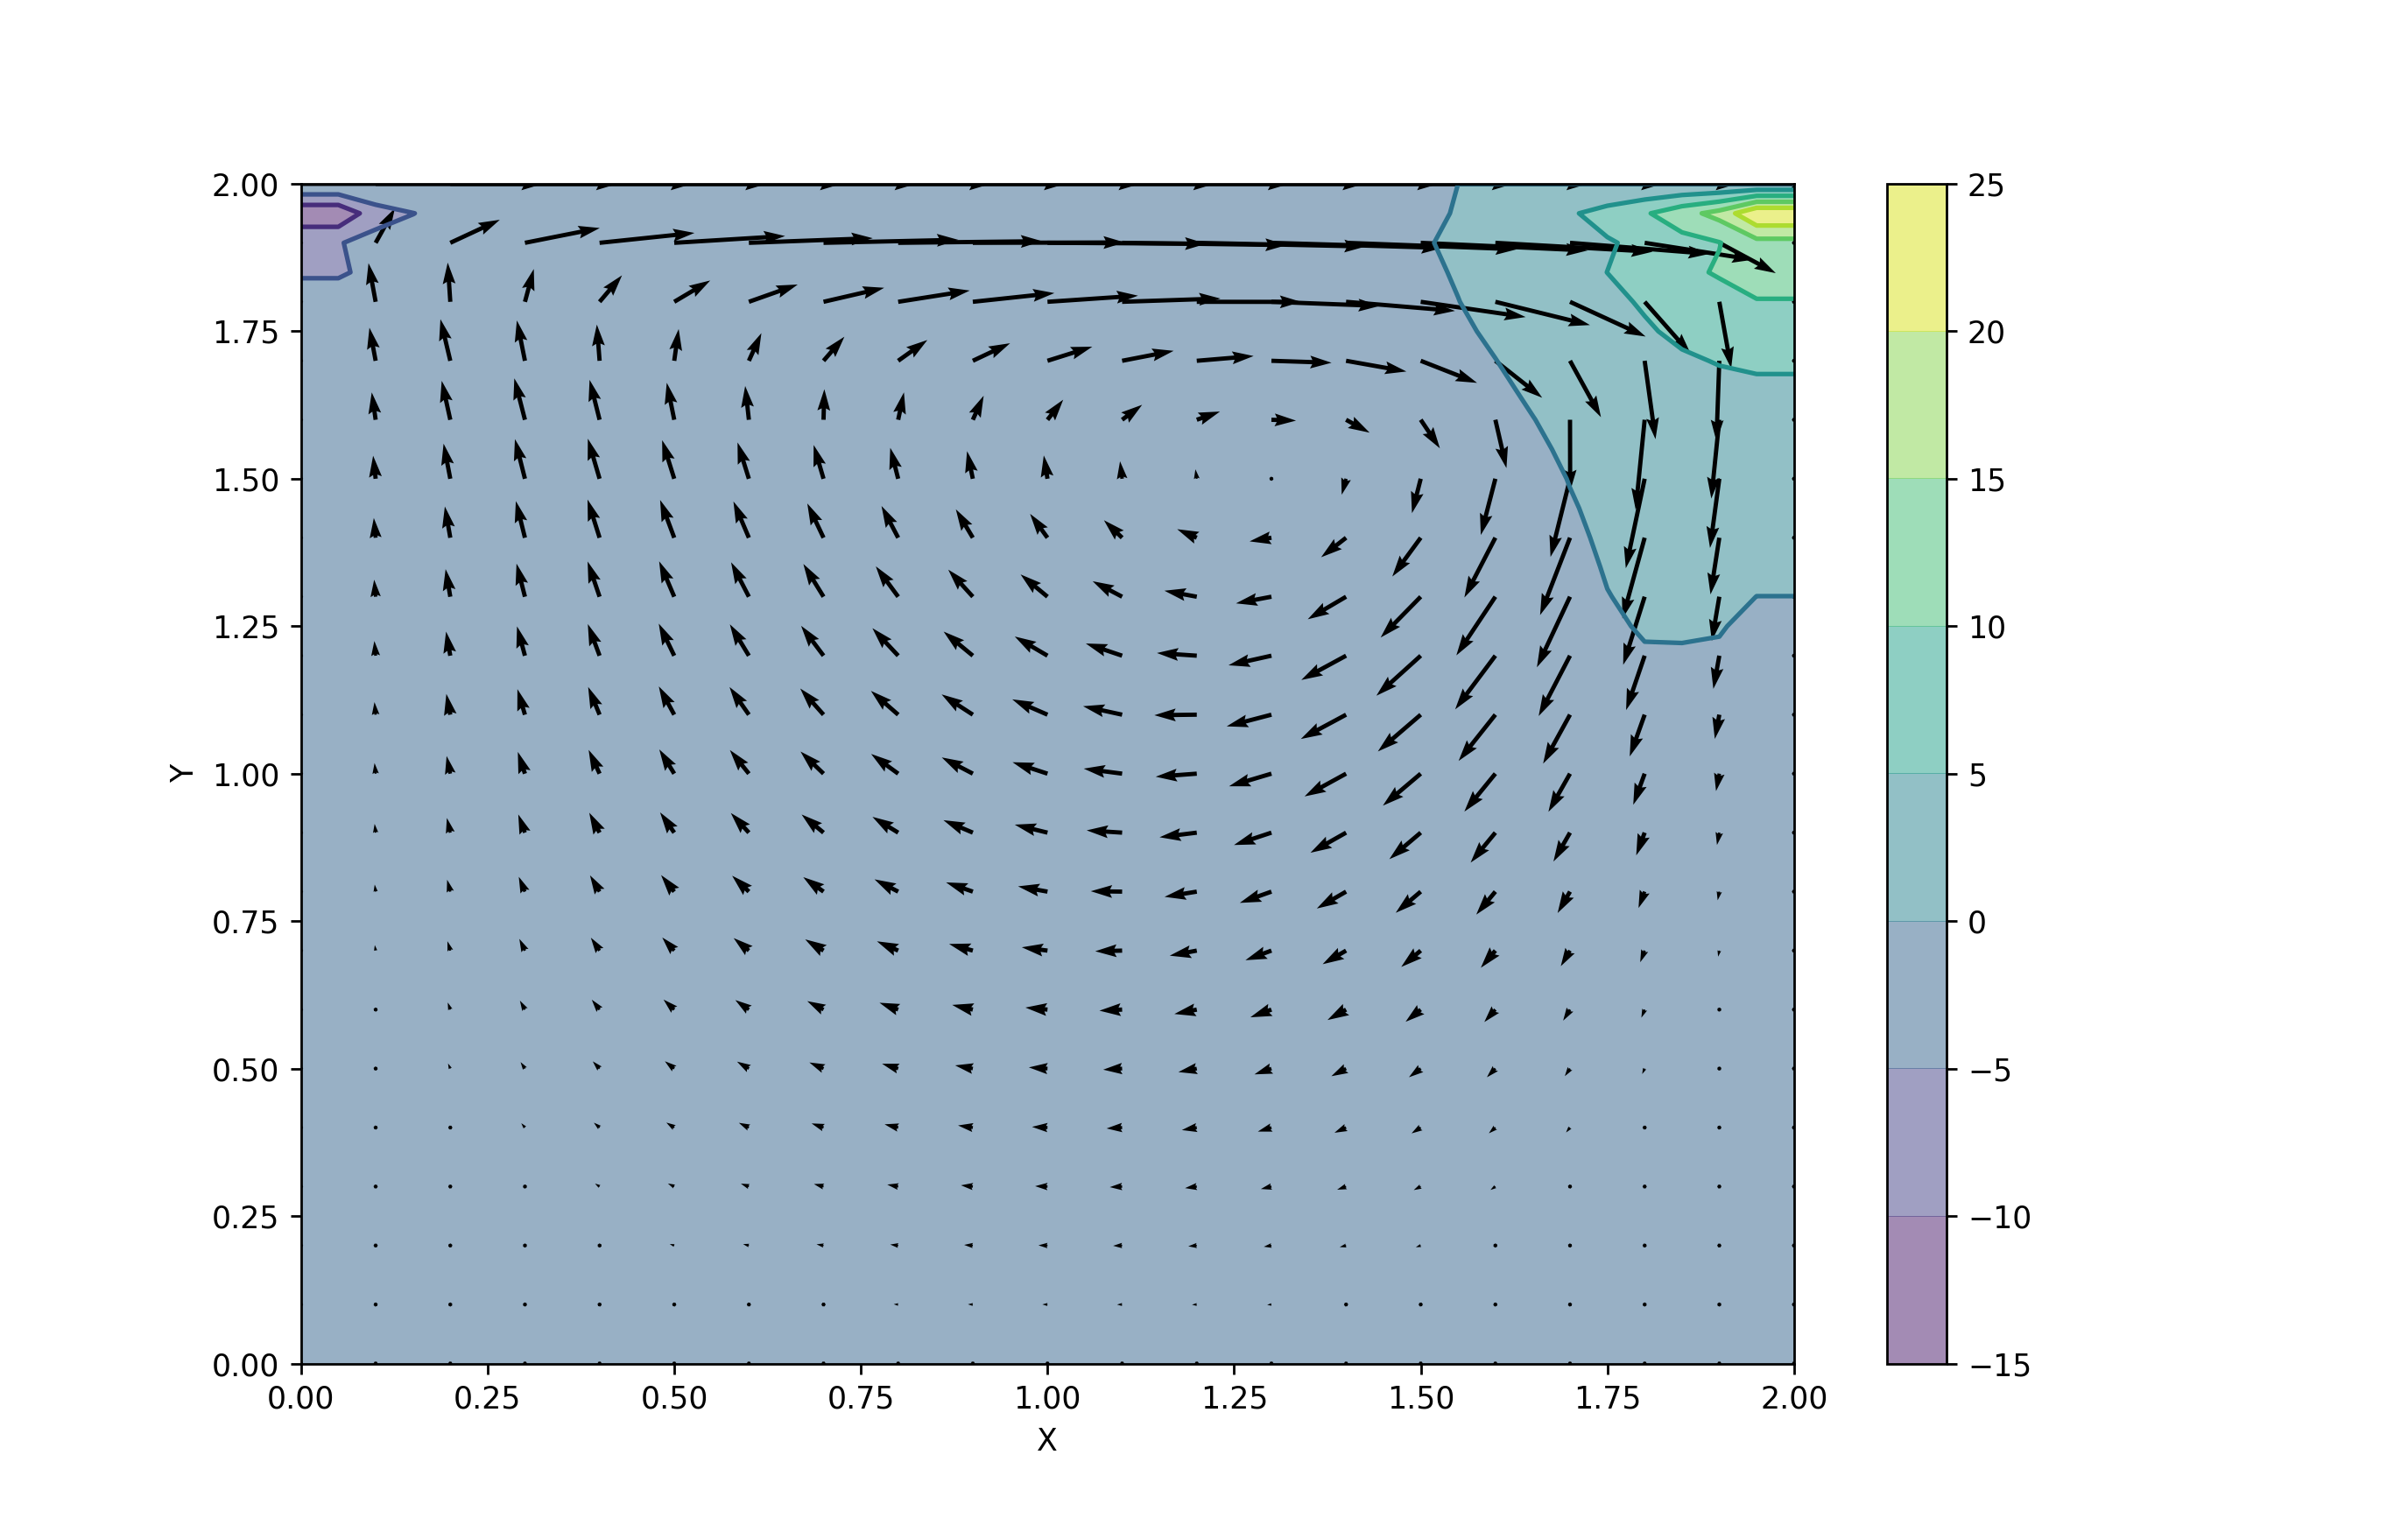

In [11]:
#Define parameters

vis = .1 # viscosity coefficient
lid_vel = 6 #velocity of the lid flow

sim = Cavity(n, x_bound, y_bound, lid_vel, dt, rho, vis)

for i in range(1000):
    sim.update()

sim.display()

<IPython.core.display.Javascript object>


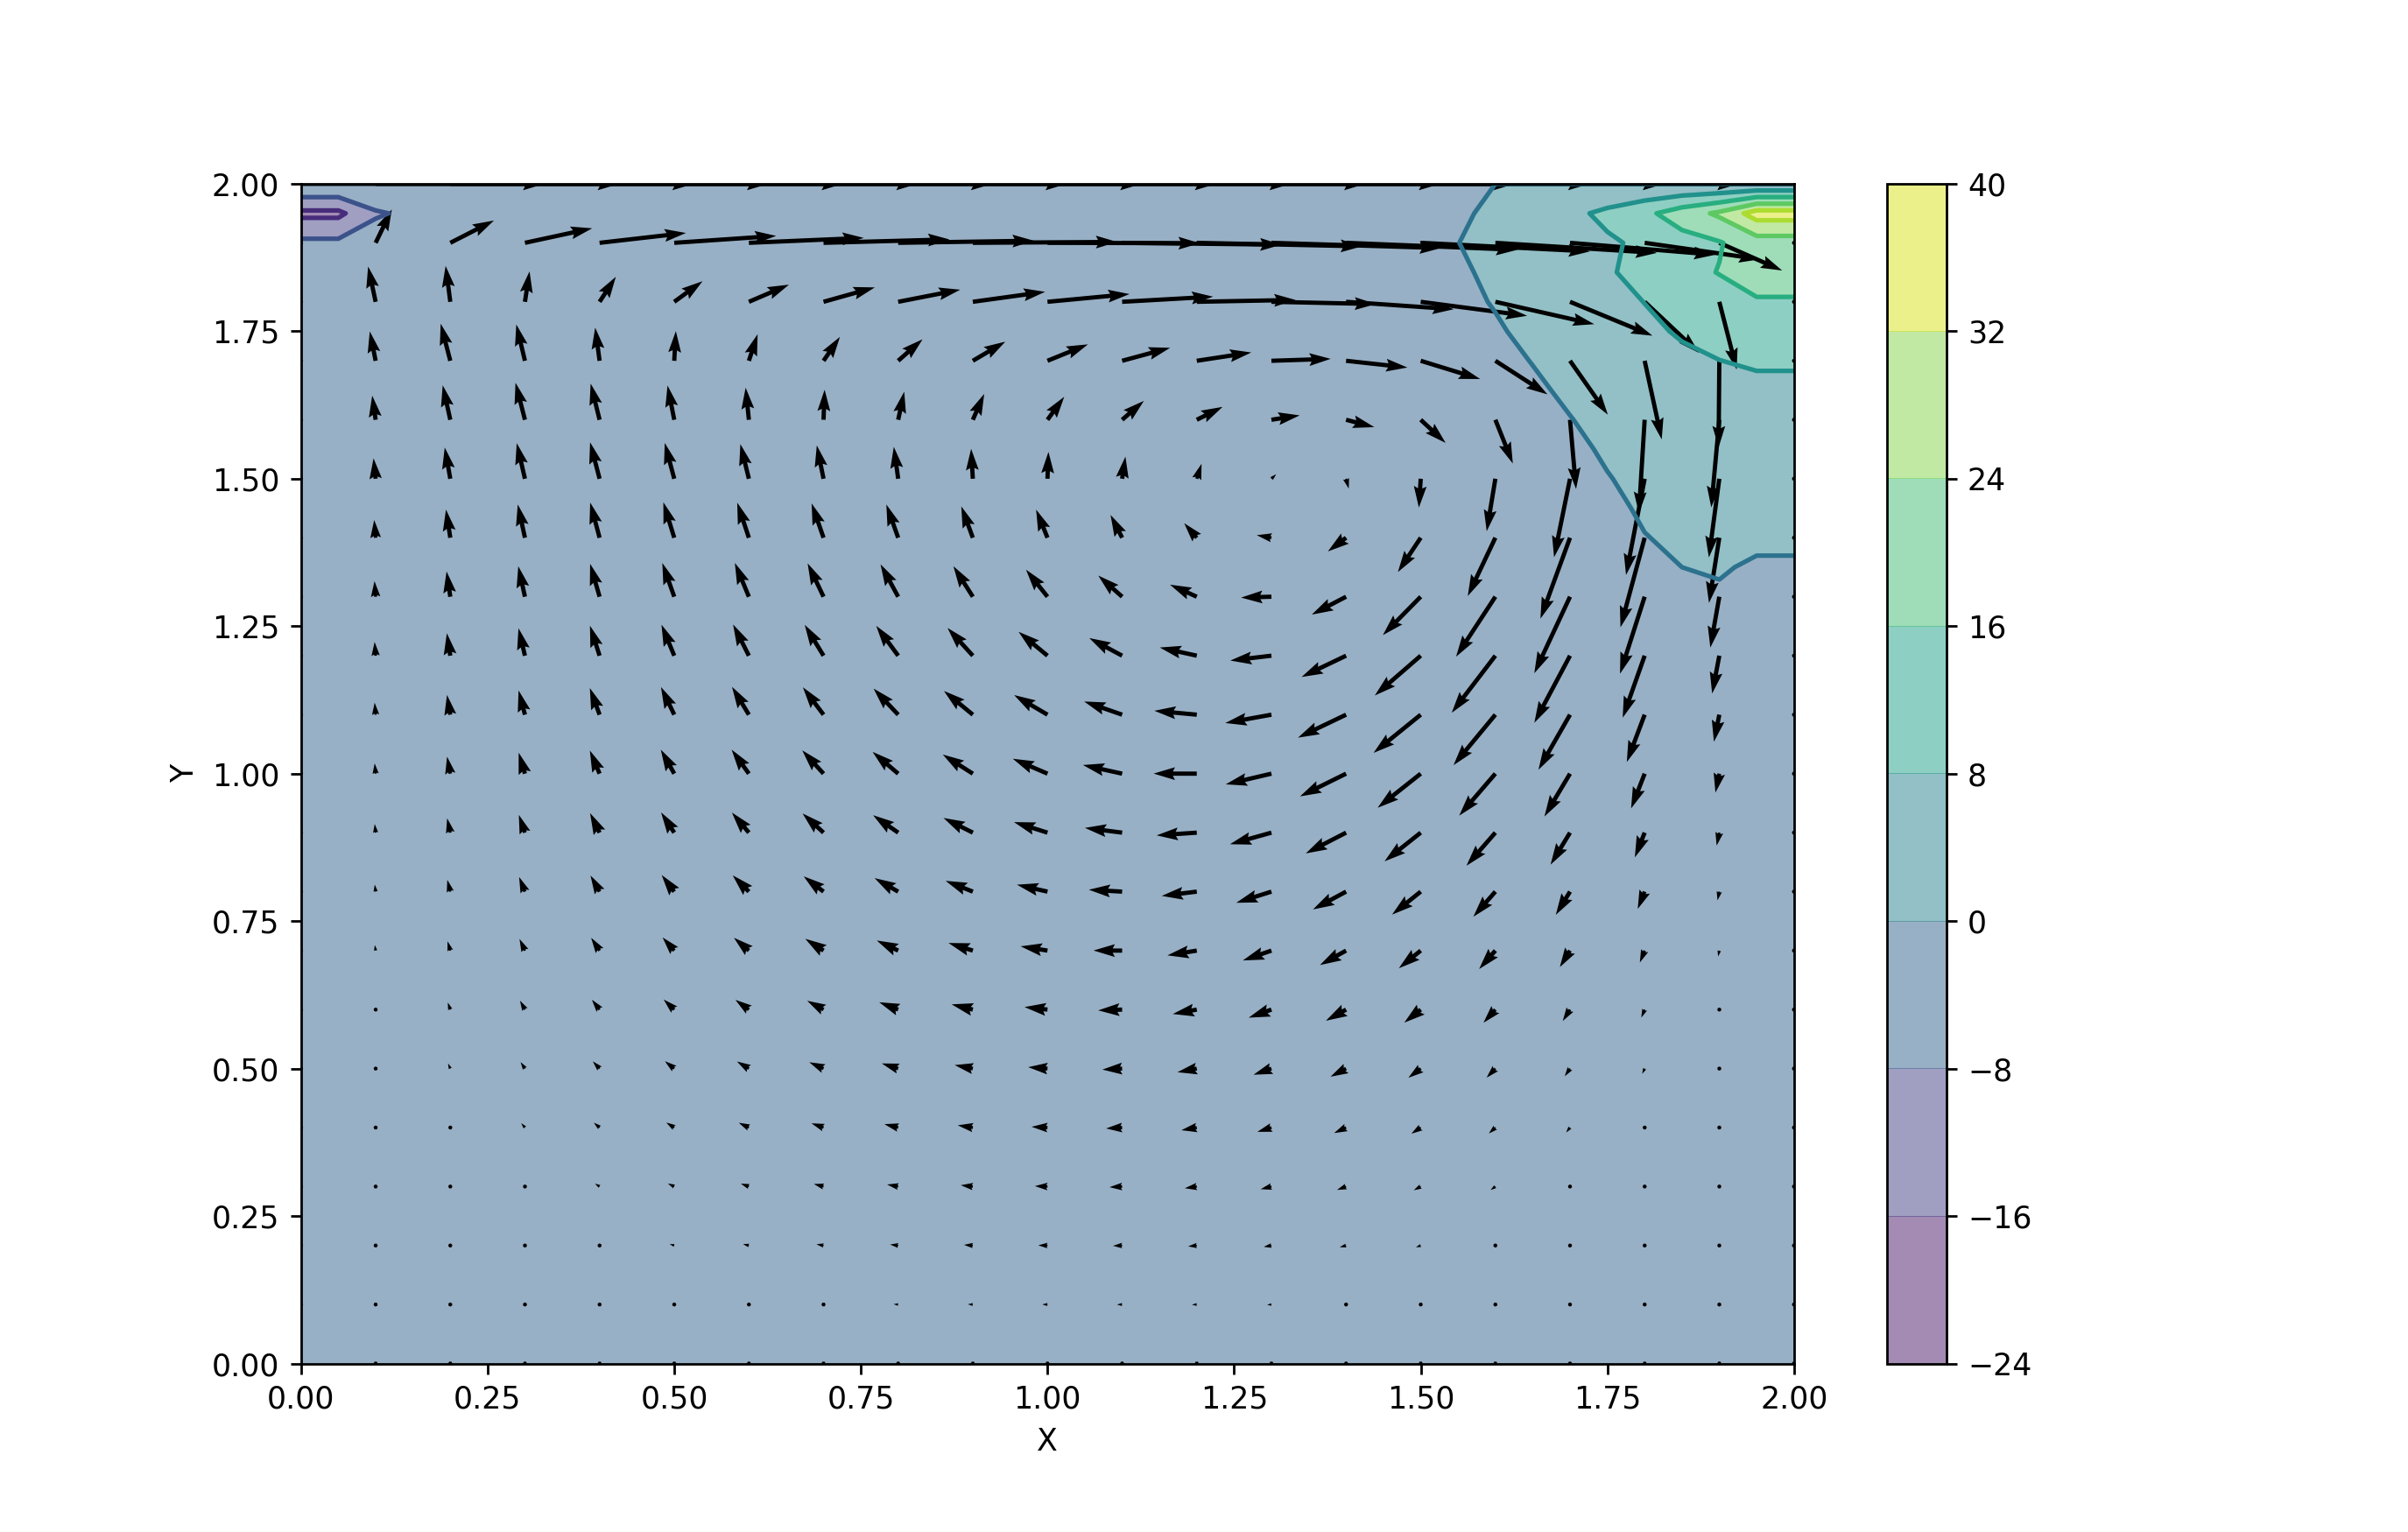

In [12]:
#Define parameters

vis = .1 # viscosity coefficient
lid_vel = 8 #velocity of the lid flow

sim = Cavity(n, x_bound, y_bound, lid_vel, dt, rho, vis)

for i in range(1000):
    sim.update()

sim.display()

## Interpretation

As the lid flow increases, the centre of the rotation moves more to the right-hand side. This makes sense, as there is a more strong pull towards this side from the top. The pressure also gets lower on the left-hand side, and higher on the right, due to the greater push on the fluid at this point to one side.

As the viscosity lowers, we see that the fluid sees less effect of the lid-driven flow towards the bottom. This is similar to the internal tension of a rope - which when high, means that the rope cannot bend as much. When we have a lower viscosity in the fluid, the turn-around in the fluid occurs in a much smaller space, and the effects are felt less towards the bottom.

These conditions can be taken to find the Reynold's number: $U_{lid}L / v$. Generally, Reynold's number measures the ratio of inertia to viscosity. We have a higher Reynold's number when we have a higher lid velocity, or a lower viscosity. As we see above, this corresponds to a higher pressure resulting from the lid-flow, and the effects of the flow being felt less towards the bottom. The effects of decreasing the velocity are similar to those of increasing the velocity of the lid.

In terms of vortices, this means that the vortex moves up and to the right the higher the Reynold's number. It seems that the drive of the vortex upwards results from a lower viscosity, and the movement to the right driven by the higher lid-flow drive.



## Animation of the Results

Here, we animate the results, so we can more easily see the evolution of the state of the system. This is done using the matplotlib animation module, and is adapted from a [Towards Data Science Tutorial](https://towardsdatascience.com/computational-fluid-dynamics-using-python-modeling-laminar-flow-272dad1ebec)

In [13]:
#Define animation function
def animate(i):    
    #Update the state of the system
    for _ in range(10):
        sim.update()
                
    #Read the state of the system
    p, u, v = sim.p, sim.u, sim.v
    
    x = np.linspace(sim.x_min, sim.x_max, sim.nx)
    y = np.linspace(sim.y_min, sim.x_max, sim.ny)
    X, Y = np.meshgrid(x,y)
    
    #Clear previous plot and make contour and stream plots for current iteration
    ax.clear()
        
    ax.set_title("Stream and quiver plot of a lid-driven cavity flow system")
    
    #Pressure field as a contour
    contf = ax.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
    
    #Pressure field boundaries
    cont = ax.contour(X, Y, p, cmap=cm.viridis)
    
    #Stream plot
    stream = ax.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])

    return contf, cont, stream,

<IPython.core.display.Javascript object>


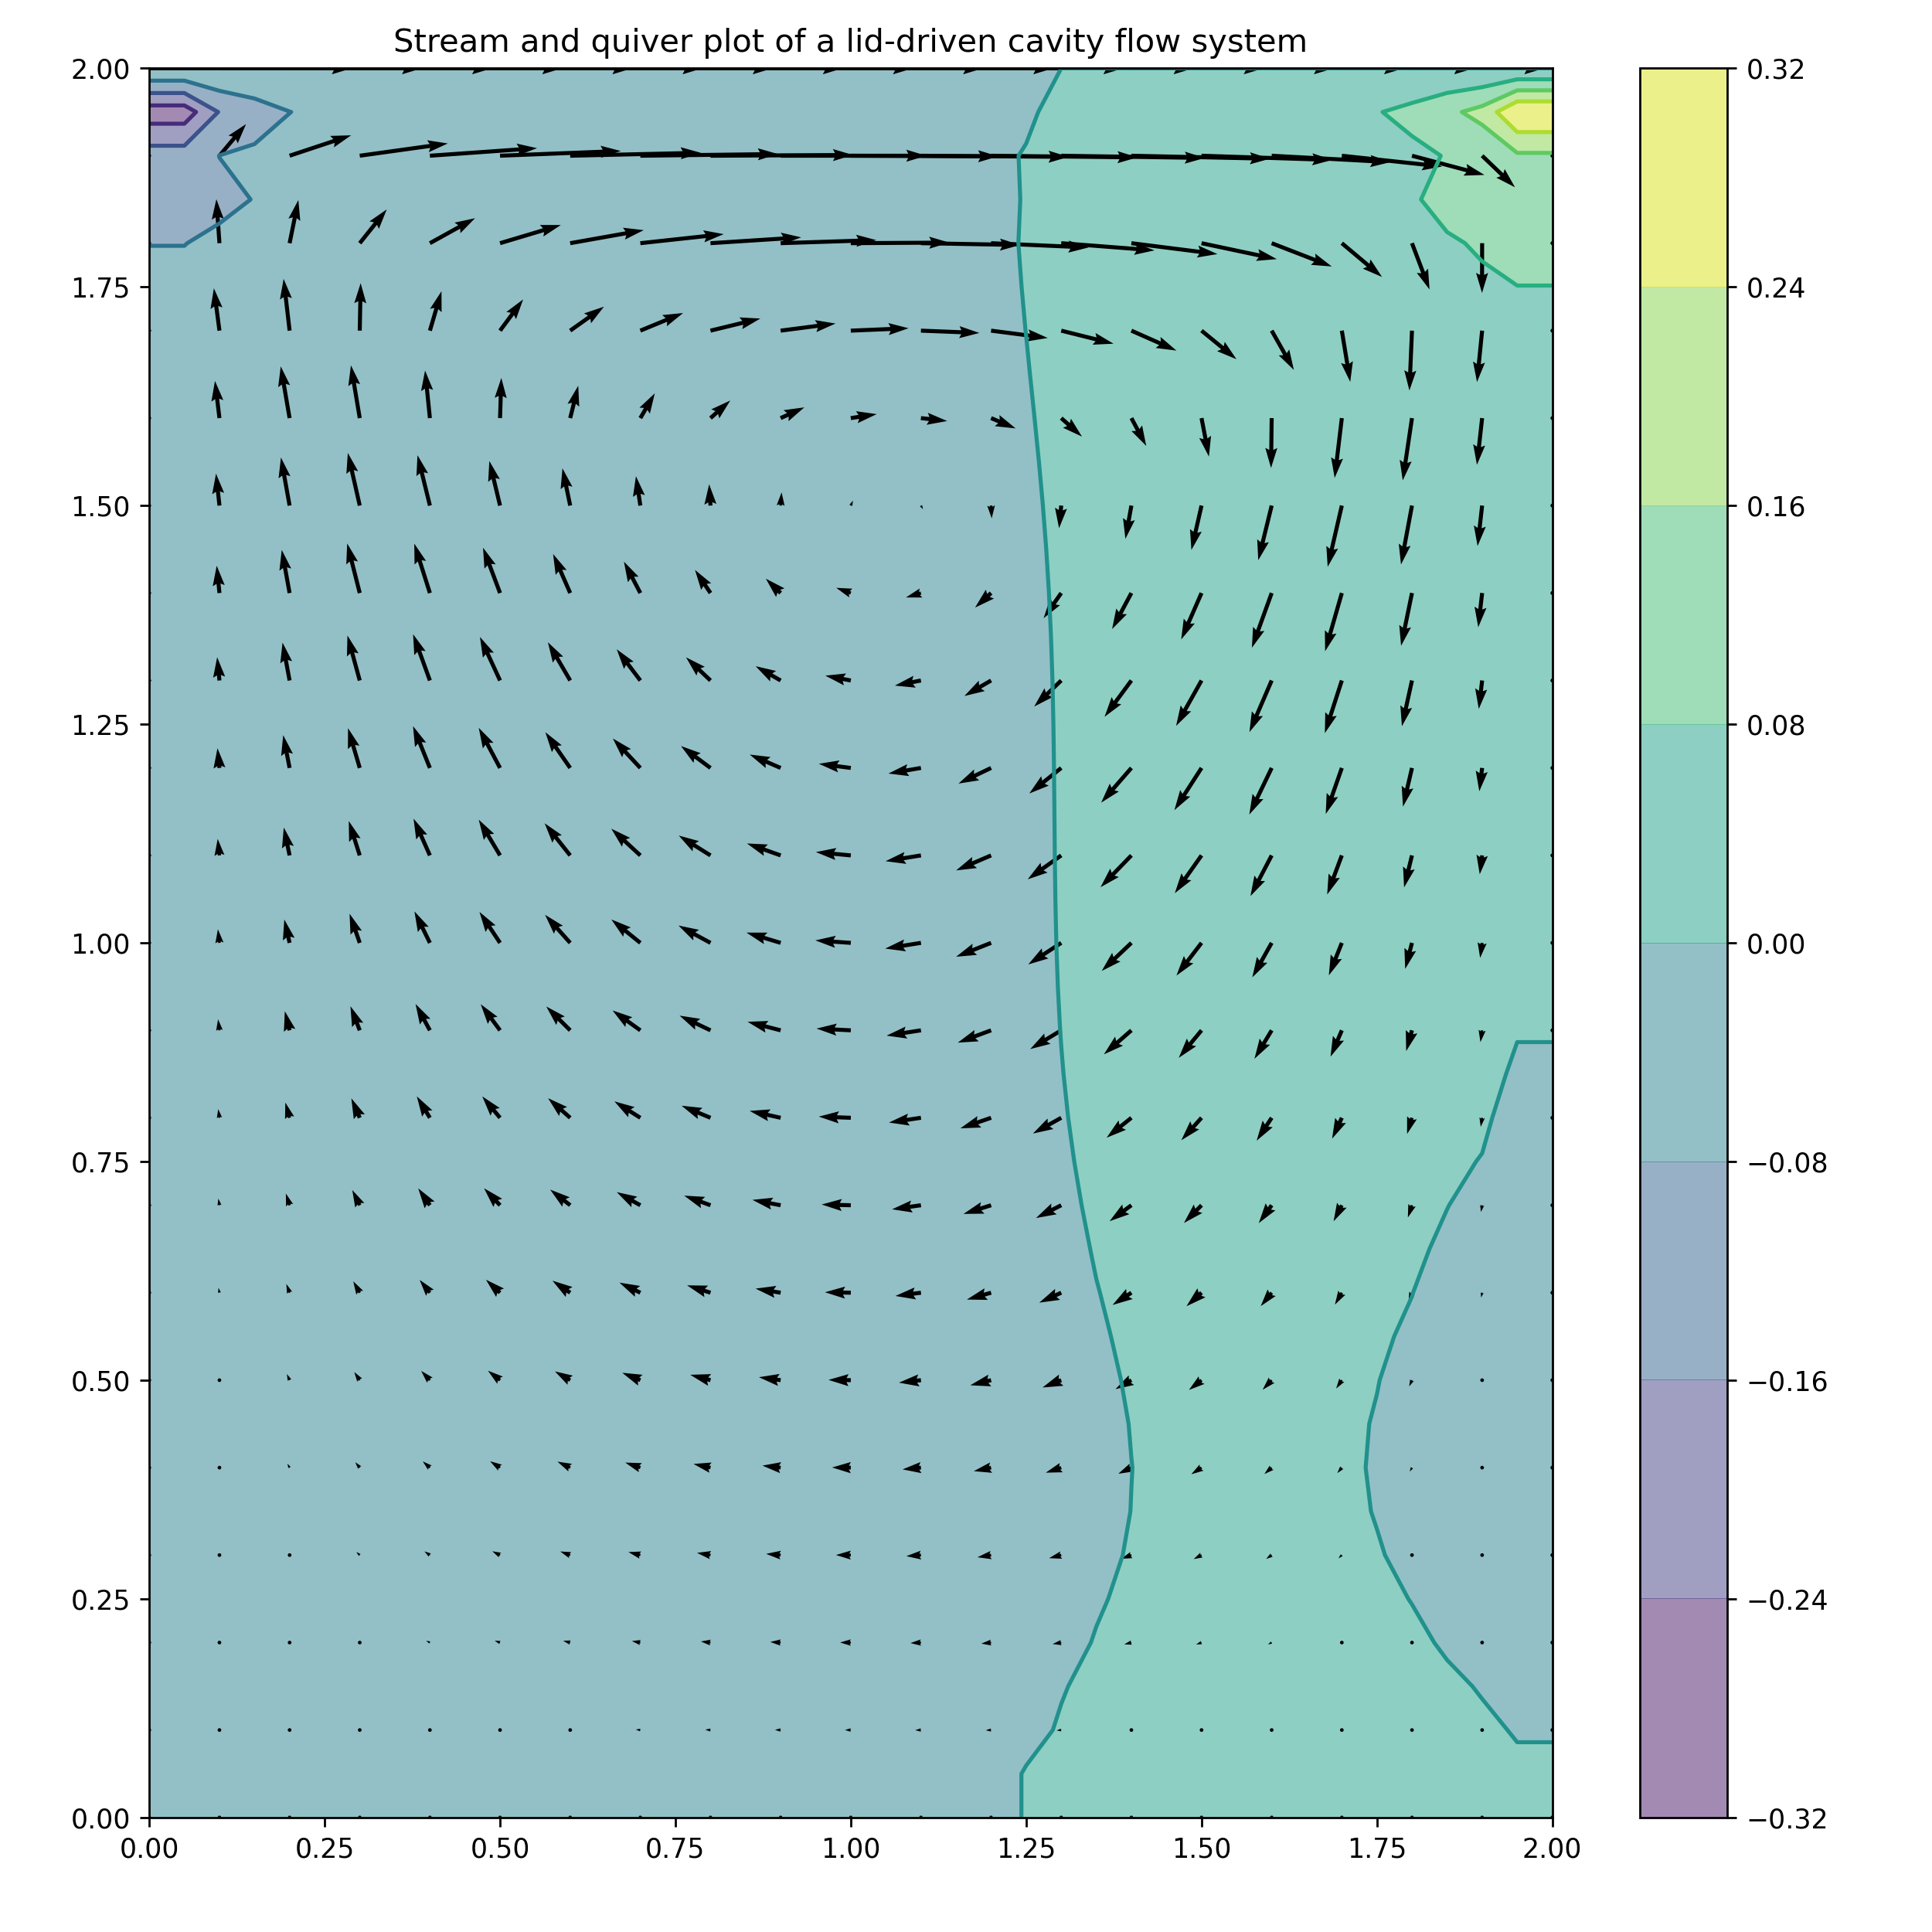

In [14]:
#Pre-animation code

#Parameters
rho = 1 # density
vis = .1 # viscosity coefficient
dt = .001 # timestep
n = (40, 40) #grid-size
x_bound = (0, 2) #x boundary size
y_bound = (0, 2) #y boundary size
lid_vel = 1 #velocity of the lid flow

#Create simulation
sim = Cavity(n, x_bound, y_bound, lid_vel, dt, rho, vis)
sim.update()

#Create blank figure
fig=plt.figure(figsize=(10,10), dpi=100)
ax=plt.axes(xlim=(sim.x_min,sim.x_max),ylim=(sim.y_min,sim.y_max))

#Create initial contour and stream plot as well as colour bar

#Read data from simulation
p, u, v = sim.p, sim.u, sim.v

x = np.linspace(sim.x_min, sim.x_max, sim.nx)
y = np.linspace(sim.y_min, sim.x_max, sim.ny)
X, Y = np.meshgrid(x,y)

#Label axes
ax.set_xlabel("$x$",fontsize=12)
ax.set_ylabel("$y$",fontsize=12)
ax.set_title("Stream and quiver plot of a lid-driven cavity flow system")


#Pressure field as a contour
contf = ax.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
fig.colorbar(contf) 

#Pressure field boundaries
cont = ax.contour(X, Y, sim.p, cmap=cm.viridis)
    
#Stream plot
stream = ax.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])

fig.tight_layout()

In [15]:
anim=animation.FuncAnimation(fig,animate,frames=np.arange(1, 500),blit=False)